Here we extract the subset of the whole dataset. We run over several hyperparameters: 
1. the amount of genes to consider for scVelo
2. mixing the pseudotime kernel with the Velocity kernel ratio


we run the main cell developement line idenfied in chan et al (https://doi.org/10.1101/2023.07.31.551262) using the velocity


In [ ]:
import pandas as pd ## importsb
import seaborn as sns
import numpy as np
import glob
import os
import random
import scipy
import matplotlib.pyplot as plt
import scvelo as scv
import networkx as nx
import anndata as ad
import cellrank as cr
import scanpy as sc

from matplotlib.patches import Rectangle


import os


In [ ]:
##uncomment for real data (clster)
#path_main = "/home/wchan210"
#path_plot = path_main + '/plots/'

##uncomment for toy data set - sam's mac
path_main = "../.."
path_plot = path_main + '/plots/'


# Check if path exists or not
isExist = os.path.exists(path_plot)
#printing if the path exists or not
print(isExist)

if not isExist:
    os.makedirs(path_plot) ##make the path where to save plots
    print(path_plot)




## 1. load in the datasets take the subsets

In [ ]:
##uncomment for real data (clster)
#wt_all =scv.read(path_main + '/CellRank/chan_wt_dynamic.h5ad') ##replace with wt all genes path 
#mut_all =scv.read(path_main + '/CellRank/chan_mut_dynamical.h5ad') ##replace with mut all genes path 

##uncomment for toy data set
wt_all =scv.read(path_main + '/labelled/all_info/chan_wt_dynamical_trimmed_with_PAX6.h5ad') ##replace with wt all genes path 
mut_all =scv.read(path_main + '/labelled/all_info/chan_mut_dynamical_trimmed_with_PAX6.h5ad') ##replace with mut all genes path 


pathway1_cells = ['RGP1','RGP2','RGP3','IN1','IP','EN','DLN','SLN','IN Progenitor'] #set the clusters included in the analysis

wt_path1 = wt_all[wt_all.obs.cluster.isin(pathway1_cells)]#.copy()
mut_path1 = mut_all[mut_all.obs.cluster.isin(pathway1_cells)]#.copy()




subset_names = ['wt','mut']
subsets = [wt_path1,mut_path1]
datasets = dict(zip(subset_names, subsets))
#mut_all = scv.read('../../labelled/all_info/chan_wt.h5ad')



In [ ]:
#mut_all[mut_all.obs.cluster.isin(pathway1_cells)] #subset the cells
##have a look at the clusters still included in the dataset

with scv.GridSpec(ncols=2) as pl: ##check the subsets
    pl.scatter(datasets['mut'], color = 'cluster', color_map ='gnuplot', title='mut path 1')
    pl.scatter(datasets['wt'], color = 'cluster', color_map='gnuplot', title='wt path 2')
#pathway1_cells = ['RGP1','RGP2','RGP3','IN Progenitor','IN1','IP','EN','DLN','SLN']



In [ ]:
##dont run

top_genes = datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index
scv.pl.scatter(datasets['mut'], basis=top_genes[:15], color = 'cluster',ncols=5, frameon=False)




scv.pl.scatter(datasets['mut'], basis=top_genes[:15], color = 'cluster',ncols=5, frameon=False)



In [ ]:
##dont run

top_genes = datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index[:20]
scv.pl.heatmap(datasets['mut'], var_names=top_genes, sortby='latent_time', col_color='cluster', n_convolve=100)

## 2. calculate the dynamics of the subset

Here we find the driver genes using sc velo only and save the figures. (use these figures to analyse kinetics of the highest likelihood genes - can we see various kinetics)

In the future it might be useful to subset the DLN track of the mutant - compare the gene expression across the latent time

## 3. use cell rank to calculate cell fates and so on

since the last round we ran with 2000 top genes -- that is the data we are working here with now

We build up the 'kernels' (term used for matrices in the cellrank documentation) from the latent time (velocity latent time/pseudotime) and velocity we calcaulted earlier. 


In [ ]:
estimators = {}

for mut_wt in datasets:
    ##find the connectivity graph (once again - done in scvelo before, combine wiht connectivity kernel)


    print(mut_wt)
    dataset = datasets[mut_wt]

    vk = cr.kernels.VelocityKernel(dataset)
    vk.compute_transition_matrix()

    ck = cr.kernels.ConnectivityKernel(dataset)
    ck.compute_transition_matrix()

    combined_kernel = 0.8 * vk + 0.2 * ck

    combined_kernel.plot_projection(color = 'cluster')

    combined_kernel.plot_random_walks(start_ixs={"cluster": "RGP1"}, max_iter=100, seed=0,save = path_plot + f'{mut_wt}_random_walks_100_steps_.png', color="cluster")

    ##pseudotime

    pk = cr.kernels.PseudotimeKernel(dataset, time_key="dpt_pseudotime")
    pk.compute_transition_matrix()

    pk.plot_projection(recompute=True,save = path_plot + f'{mut_wt}_pseudotime_cellrank_embedding.png', color = 'cluster')

    #plots only the peseudotime with streamlines
    

    ##estimate the end and starting points
    estimator =  cr.estimators.GPCCA(combined_kernel) ##use the combined kernel to compute the macrostates 

    estimator.fit(cluster_key="cluster", n_states= [4,8]) ##fit between four and eight states

    estimator.plot_macrostates(which="all", discrete=True, legend_loc="right") ##plot the states found

    estimator.predict_terminal_states(allow_overlap=True) ##predict the terminal states
    estimator.predict_initial_states(allow_overlap=True)  ##predict the initial states

    estimator.plot_macrostates(which="initial", discrete=True,legend_loc="right" ,save = path_plot + f'{mut_wt}_initial_states_auto.png') ##plot initial
    estimator.plot_macrostates(which="terminal",discrete=True, legend_loc="right",save = path_plot + f'{mut_wt}_terminal_states_auto.png')


    estimator.compute_fate_probabilities()

    estimator.plot_fate_probabilities(same_plot=False,dpi = 300,save = path_plot + f'{mut_wt}_cell_fates_combined_kernel.png')


    estimatorPK =  cr.estimators.GPCCA(pk) ##use the pesudotime kernel to compute the macrostates

    estimatorPK.fit(cluster_key="cluster", n_states= [4,7])
    estimatorPK.plot_macrostates(which="all", discrete=True, legend_loc="right")

    estimatorPK.plot_macrostates(which="all", discrete=True, legend_loc="right") ##plot the results

    estimatorPK.predict_terminal_states(allow_overlap=True)
    estimatorPK.predict_initial_states(allow_overlap=True)

    estimatorPK.plot_macrostates(which="initial", discrete=True,legend_loc="right" ,save = path_plot + f'{mut_wt}_pseudotime_initial_states_auto.png') ##plot initial
    estimatorPK.plot_macrostates(which="terminal",discrete=True, legend_loc="right",save = path_plot + f'{mut_wt}_Pseudotime_terminal_states_auto.png')


    estimatorPK.compute_fate_probabilities()

    estimatorPK.plot_fate_probabilities(same_plot=False,dpi = 300,save = path_plot + f'{mut_wt}_cell_fates_pseudotime_kernel.png')

    dataset.write(path_main + f'/{mut_wt}_all_genes_pseudotime_velocity_latent_times.h5ad', compression="gzip")

    estimators[mut_wt] = estimator
    estimators[f'{mut_wt}_PK'] = estimatorPK
    
    











## 3. build the kernels and transition probability graphs

## 4. calculate the driver genes for each cell fate

In [ ]:
for cond in estimators:
    estimator = estimators[cond]

    driver_clusters = ['RGP1', 'RGP2', 'RGP3', 'IP']

    if cond == ('mut'):

        
        drivers_df = estimator.compute_lineage_drivers(
            lineages=["DLN","IN1_2"], cluster_key = 'cluster', clusters = driver_clusters
        )
    if cond == 'mut_PK':

        drivers_df = estimator.compute_lineage_drivers(
            lineages=["DLN_1","IN1_2",'DLN_2','IN1_1'], cluster_key = 'cluster', clusters = driver_clusters
        )
        
    else:
        drivers_df = estimator.compute_lineage_drivers(
            lineages=["DLN"], cluster_key = 'cluster', clusters = driver_clusters
        )

    if 'mut' in cond:
        adata = datasets['mut']

    else:
        adata = datasets['wt']
    if cond == 'mut_PK':

        adata.obs["fate_probabilities_DLN"] = estimator.fate_probabilities["DLN_1"].X.flatten()
    else:
        adata.obs["fate_probabilities_DLN"] = estimator.fate_probabilities["DLN"].X.flatten()

    

    sc.pl.embedding(
            adata,
            basis="umap",
            color=["fate_probabilities_DLN"] + list(drivers_df.index[:8]),
            color_map="viridis",
            s=10,
            ncols=3,
            vmax="p96",
            title = f'{cond}_probability'
            #save = path_plot + 'fate_probabilities_DLN.png'
        )


    

    drivers_df.head()

    drivers_df.to_csv('/home/wchan210/pk_mut_cellfatecorr.csv')
    

In [ ]:
##save the inferred driver genes
drivers_df.to_csv('/home/wchan210/pk_mut_cellfatecorr.csv')

In [ ]:
df_corr = pd.read_csv('/Users/samuelheczko/Downloads/pk_mut_cellfatecorr.csv' ,header=0,index_col = 'Gene')

In [ ]:
df_corr.head()

In [ ]:
#np.corrcoef(df_corr.DLN_1_corr.dropna().values,df_corr.DLN_2_corr.dropna().values)

#plt.scatter(df_corr.DLN_1_corr.dropna().values,df_corr.IN1_2_corr.dropna().values)


(df_corr.DLN_1_corr.dropna() - df_corr.IN1_2_corr.dropna()).abs().nlargest(10)






In [ ]:
ip_genes = mut_all[mut_all.obs.cluster == 'IP'].var.fit_likelihood.sort_values(ascending = False).index

#datasets['mut'].var['fit_likelihood'].sort_values(ascending=False).index

## 5. looking at the wt small subsets (copy paste from here)

In this part we build pipline to subset a region in dataset using cluster ids and select rectangular regions within the UMAP embedding. For our data we have identified a 'bridge' which point for our data is to look at the IP cells which turn around from the path which in the mutant leads to inhibiotory tract.

In [ ]:
##we start by subsetting the data
ips_mut = mut_all[mut_all.obs.cluster == 'IP'].copy()
ips_wt = wt_all[wt_all.obs.cluster == 'IP'].copy()

ips_dict = {}
ips_dict['wt'] = ips_wt ##set the subsets as dictionary for easier looping
ips_dict['mut'] = ips_mut


INP_mut = wt_all[wt_all.obs.cluster == 'IN Progenitor'].copy()


overlapping_genes_mut_wt = list(set(INP_mut.var_names) & set(terminal_state1.var_names)) #comment out with all genes




In [ ]:
##define helper function which finds poiutns inisde a rectangle

def points_inside_rectangle(rectangle, points):
    """
    Check which points are inside the given rectangle.

    Parameters:
    - rectangle: Tuple of (x, y, width, height)
    - points: NumPy array of points, each represented as (x, y)

    Returns:
    - NumPy array of points that are inside the rectangle
    """
    x, y, width, height = rectangle

    # Create a bounding box for the rectangle
    rect_x, rect_y = x, y
    rect_width, rect_height = width, height
    rect_corners = np.array([[rect_x, rect_y], [rect_x + rect_width, rect_y + rect_height]])

    # Check which points are inside the bounding box using vectorized operations
    inside_bbox = np.all(points >= rect_corners[0], axis=1) & np.all(points <= rect_corners[1], axis=1)

    # Return the points that are inside the bounding box
    points_inside = points[inside_bbox]

    return points_inside,inside_bbox

def get_rectangle_coords(coords): #x,y,x,y,width,height
    return (coords[0],coords[1],coords[0] + coords[2],coords[1] + coords[3])


## 1a set the boundaries of the subsets studied

Here we set up the boundaries of the rectangles in which we will look at the gene expression and velocity


['velocity vecotors', 'subset 1 boundaries', 'velocity vectors 1', 'subset 2 boundaries', 'velocity vectors 2', 'subset 3 boundaries', 'velocity vectors 3', 'subset 4 boundaries', 'velocity vectors 4']
['velocity vecotors', 'subset 1 boundaries', 'velocity vectors 1', 'subset 2 boundaries', 'velocity vectors 2', 'subset 3 boundaries', 'velocity vectors 3', 'subset 4 boundaries', 'velocity vectors 4']


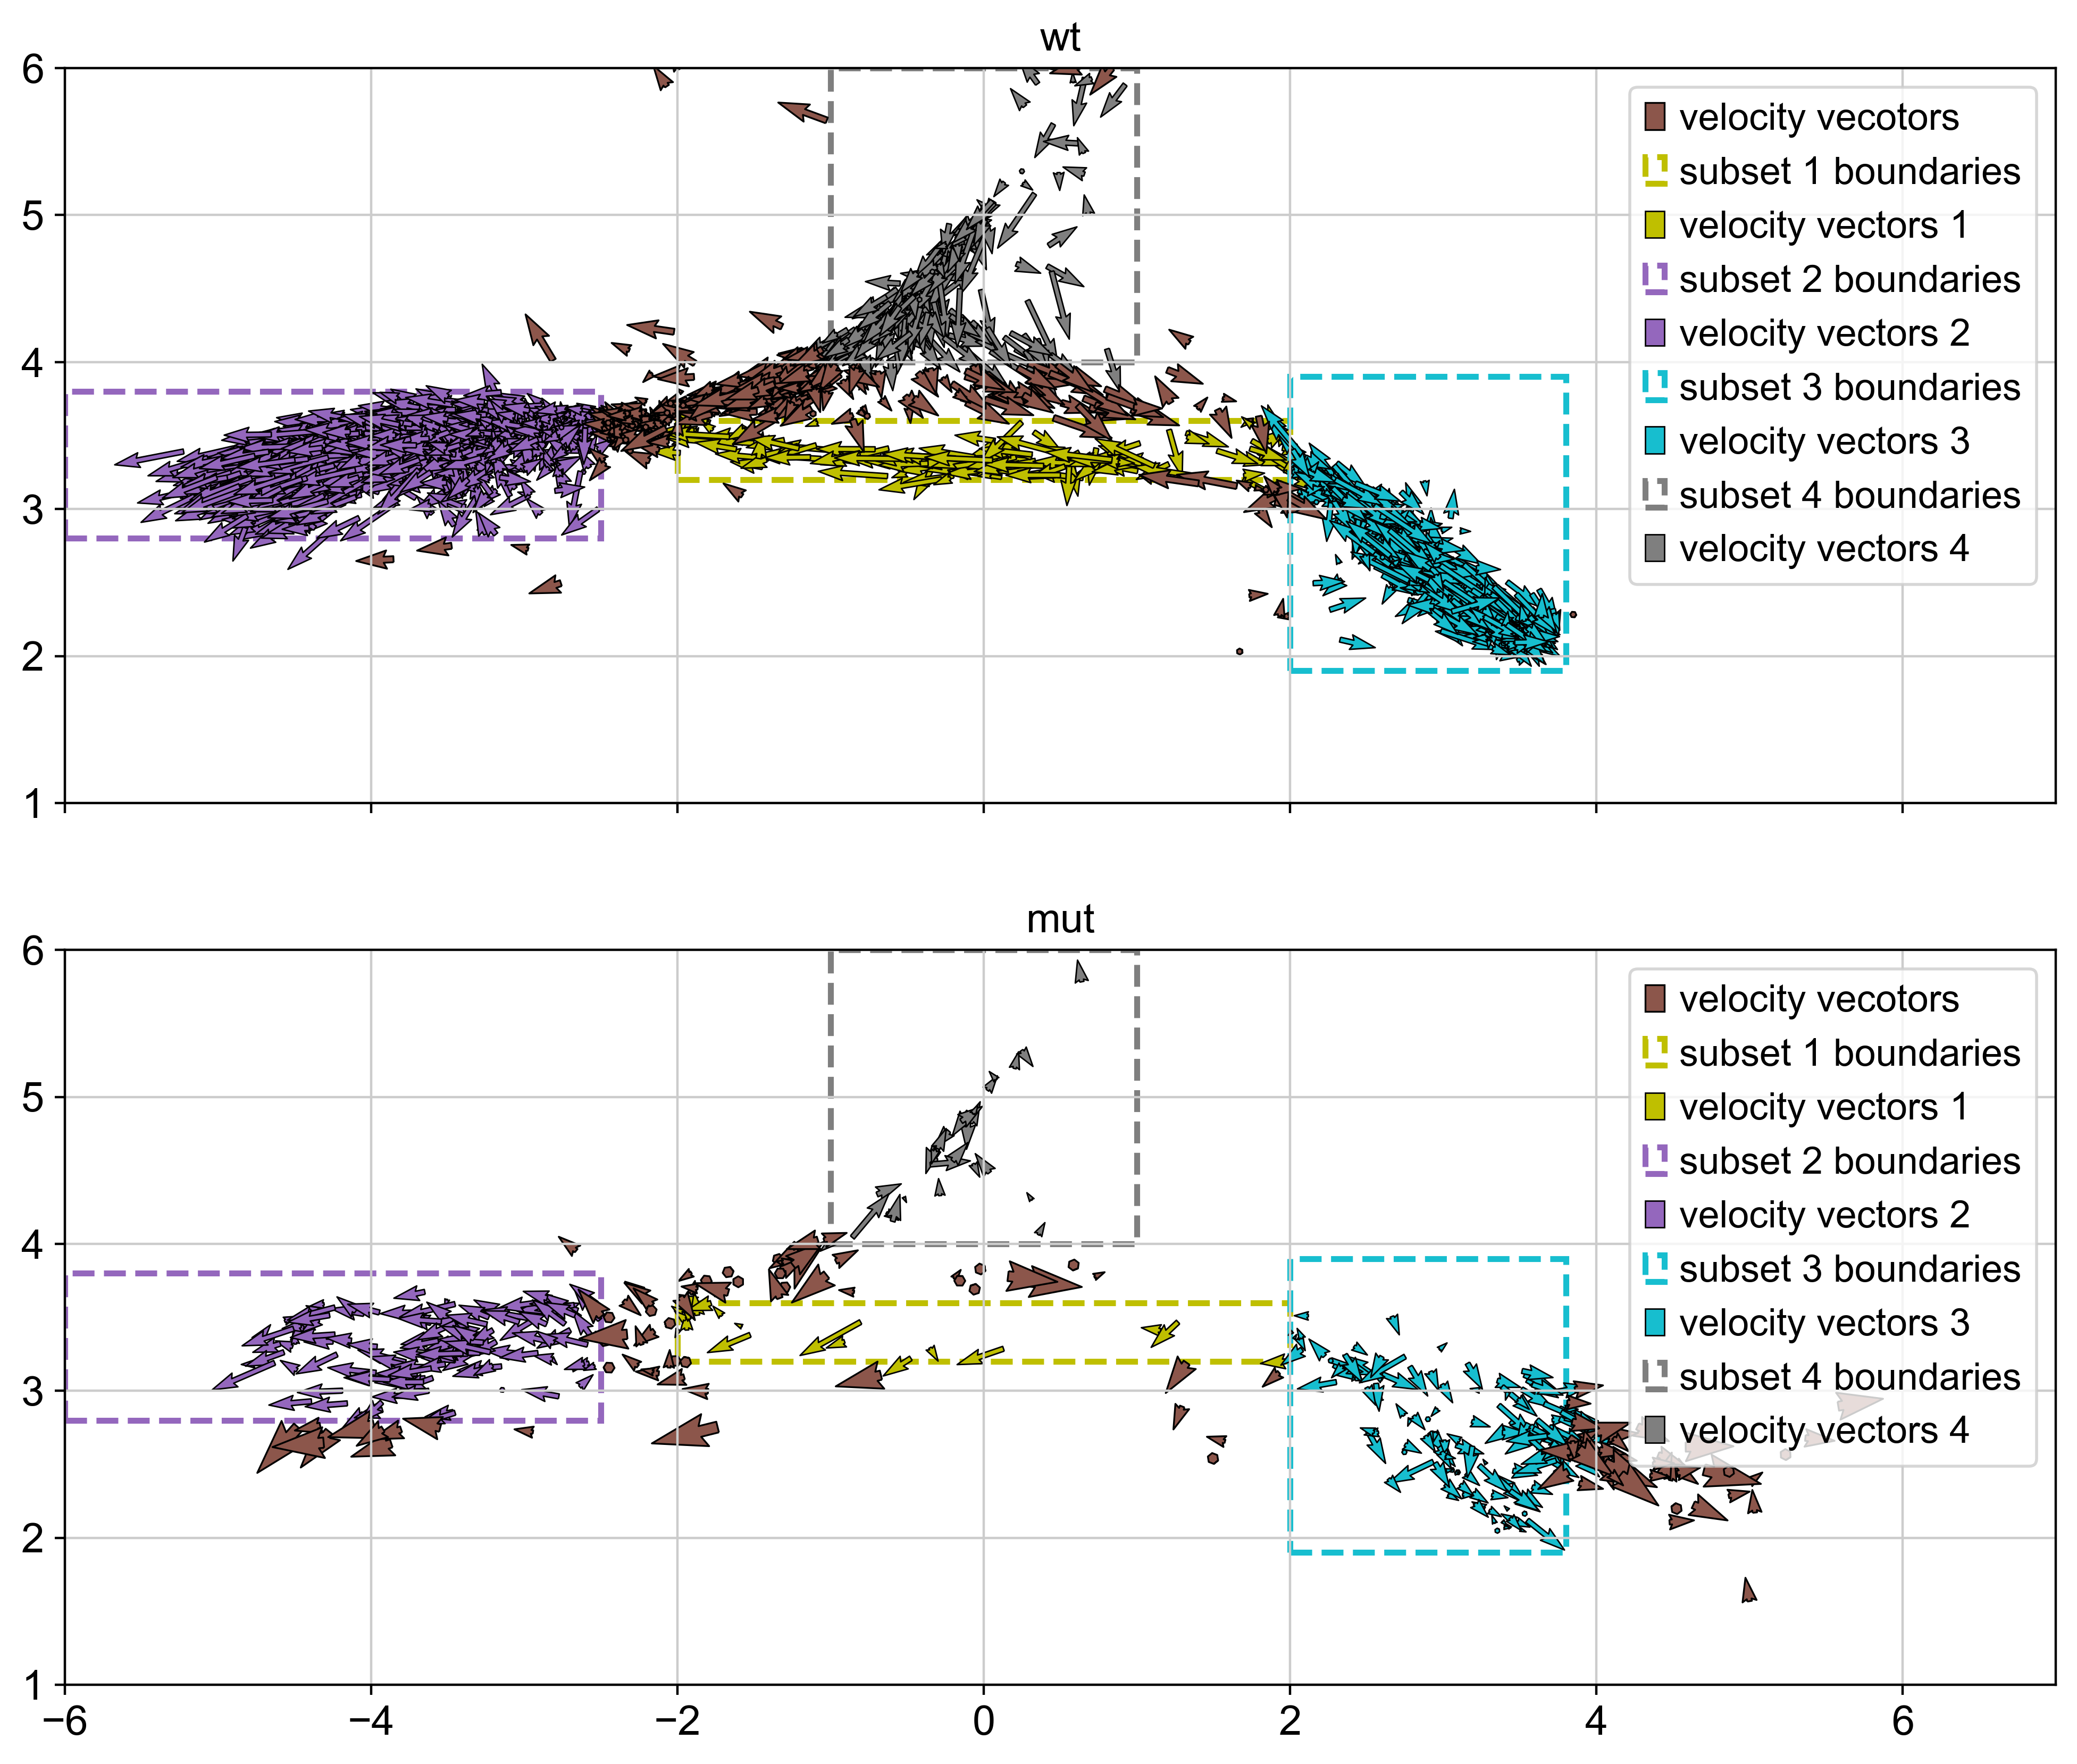

In [1419]:
##set the square you want to subset

rectangles = {}
rectangle_coords = {}

rectangles['1'] = (-2,3.2,4,0.4) #x,y,width,height - Set here the rectangle limits ##the bridge coordinates
rectangles['2'] = (-6,2.8,3.5,1) ##x,y,width,height - Set here the rectangle 2 limits  ##the DLN pointing pathway 
rectangles['3'] = (2,1.9,1.8,2) ##the IN pointing pathway 
rectangles['4'] = (-1,4,2,2) ##the IN pointing pathway 



rectangle_colors = {'1': 'y', '2': '#9467bd','3' : '#17becf','4' : '#7f7f7f'} ##set the colours

#plot_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'] example colours(chat gpt )


##add more rectangles and colours if needed

for rectangle in rectangles:
    rectangle_coords[rectangle] = get_rectangle_coords(rectangles[rectangle]) ##manipualte then to get the coords
#rectangle_coords_np = np.array([[rectangle_coords[0],rectangle_coords[1]],[rectangle_coords[2],rectangle_coords[3]]])

##plot the subset and find the cells in the 'bridge' 
fig, ax = plt.subplots(nrows = 2,sharex=True)
fig.set_figheight(10)
fig.set_figwidth(12)

#rectangle_coords = (rectangle_values[0],rectangle_values[1],rectangle_values[0] + rectangle_values[2],rectangle_values[1] + rectangle_values[3])
#rectangle_coords_np = np.array([[rectangle_coords[0],rectangle_coords[1]],[rectangle_coords[2],rectangle_coords[3]]])

masks_all = {} #intialise dictionary for the index mask containgn the points within the rectangle

for genotype_i, genotype in enumerate(ips_dict):
    masks = {} ##intialise dictionarys to take the different subsets
    inside = {}
    for rectangle in rectangles:
    

        inside[rectangle],bbx = points_inside_rectangle(rectangles[rectangle],ips_dict[genotype].obsm['X_umap'])
        masks[rectangle] = bbx



        ax[genotype_i].set_title(genotype)

        ax[genotype_i].set_ylim((1,6))
        ax[genotype_i].set_xlim((-6,7))


    

        rect = Rectangle((0,1),1,1,fill = False,ls = '--', lw = 2,label = f'subset {rectangle} boundaries',color = rectangle_colors[rectangle]) ##draw the rectangle on the plot
        rect.set_bounds(rectangles[rectangle])
        ax[genotype_i].add_patch(rect)
    
        

        #ax[genotype_i].scatter(inside[:,0],inside[:,1],s = 5.5,color = 'r',label = 'bridge cells')

        

        ax[genotype_i].quiver(ips_dict[genotype].obsm['X_umap'][bbx,0],ips_dict[genotype].obsm['X_umap'][bbx,1],ips_dict[genotype].obsm['velocity_umap'][bbx,0],ips_dict[genotype].obsm['velocity_umap'][bbx,1],label = f'velocity vectors {rectangle}',color = rectangle_colors[rectangle], edgecolor = 'k', linewidth = 0.5,scale = 1.5,width = 0.0025)
    


    arrays_list = list(masks.values())
    result_array = np.any(arrays_list, axis=0) ##take the points which are not in any of the rectangles
    sum_ = result_array
    masks['and'] = result_array
    ax[genotype_i].quiver(ips_dict[genotype].obsm['X_umap'][~sum_,0],ips_dict[genotype].obsm['X_umap'][~sum_,1],ips_dict[genotype].obsm['velocity_umap'][~sum_,0],ips_dict[genotype].obsm['velocity_umap'][~sum_,1],label = 'velocity vecotors', color = '#8c564b',edgecolor = 'k', linewidth = 0.6,scale = 1.7)
    
    handles, labels = ax[genotype_i].get_legend_handles_labels()

    # Change the order of handles and labels
    new_order =   list(np.roll(np.arange(len(labels)), shift=1)) # Change the order as needed
    handles = [handles[i] for i in new_order]
    labels = [labels[i] for i in new_order]
    print(labels)

    ax[genotype_i].legend(handles,labels)

    masks_all[genotype] = masks

In [1355]:

## add the subset labels to the dataset

ips_dict['wt'].obs['subset'] = 'None'
ips_dict['wt'].obs['subset'][masks_all['wt']['1']] = 'bridge'
ips_dict['wt'].obs['subset'][masks_all['wt']['2']] = 'DLN'
ips_dict['wt'].obs['subset'][masks_all['wt']['3']] = 'terminal'
ips_dict['wt'].obs['subset'][masks_all['wt']['4']] = 'start'


ips_dict['wt'].obs['subset']

#sc.pl.embedding(ips_dict['wt'][ips_dict['wt'].obs.bridge == True],basis='umap')


CellID
19071MJpool03__1:AAACCCAGTCTACATGx          DLN
19071MJpool03__1:AAACGCTAGATGAAGGx       bridge
19071MJpool03__1:AAACGCTGTCATGACTx     terminal
19071MJpool03__1:AAAGAACCATCAGTCAx     terminal
19071MJpool03__1:AAAGAACTCGTAACTGx     terminal
                                         ...   
19071MJpool03__13:TTTCGATCAAGATTGAx        None
19071MJpool03__13:TTTCGATCACCGGTCAx         DLN
19071MJpool03__13:TTTGACTCATGACTCAx         DLN
19071MJpool03__13:TTTGGAGGTCGCTTAAx         DLN
19071MJpool03__13:TTTGGTTGTGTGTCGCx        None
Name: subset, Length: 2181, dtype: object

In [ ]:
#calcuate the t tests - save plots
sc._settings.ScanpyConfig(figdir=path_plot)
sc.set_figure_params(dpi=80,dpi_save=200)

sc.tl.rank_genes_groups(ips_dict['wt'], 'subset', method='t-test',reference = 'terminal')
sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False)
#
df_tvalues_start_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'start')
df_tvalues_DLN_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'DLN')
df_tvalues_bridge_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'bridge')

df_tvalues_bridge_v_term.to_csv(path_main + '/data/brdige_v_term.csv')
df_tvalues_DLN_v_term.to_csv(path_main + '/data/DLN_v_term.csv')
df_tvalues_start_v_term.to_csv(path_main + '/data/start_v_term.csv')







#DLN




In [ ]:
list(set(df_tvalues_DLN_v_term.nsmallest(200,'scores').names.values) & set(df_tvalues_start_v_term.nlargest(200,'scores').names.values))


list(set(df_tvalues_DLN_v_term.nlargest(150,'scores').names.values) & set(df_tvalues_start_v_term.nsmallest(150,'scores').names.values))



In [ ]:
ips_dict['genotype'].obsm

In [ ]:
ips_dict['wt'].uns['rank_genes_groups']

In [ ]:
##find the gene lists - total six of them - the highest velocity and expression in the rectangle, highly outside the rectangle, high differenece and same for velocity
sc.set_figure_params(dpi=80,dpi_save=200)
how_many = 21 ##how many genes to examine

gene_vel_dict = {} ##intialise dictiornary for velocities

gene_vel_dict['bridge'] = ips_wt.layers['velocity'][masks['wt'],:].mean(axis = 0) ##find the mean velocity over the cells of each gene - bridge
gene_vel_dict['exlcld_bridge'] = ips_wt.layers['velocity'][~masks['wt'],:].mean(axis = 0) ##find the mean velocity of each gene - excluding
gene_vel_dict['dif'] = gene_vel_dict['bridge'] - gene_vel_dict['exlcld_bridge'] ##find the mean velocity of each gene - difference

gene_exp_dict = {} ##intialise dictiornary for expressions

gene_exp_dict['bridge'] = np.squeeze(np.asarray(ips_wt.X[masks['wt'],:].mean(axis = 0))) ##find the mean expressions of each gene - bridge
gene_exp_dict['exlcld_bridge'] = np.squeeze(np.asarray(ips_wt.X[~masks['wt'],:].mean(axis = 0))) ##find the mean expressions of each gene - excluding bridge
gene_exp_dict['dif'] = gene_exp_dict['bridge'] - gene_exp_dict['exlcld_bridge'] ##find the mean velocity of each gene - difference

genes_top_vel = {}

genes_top_exp = {}


for cond in gene_vel_dict:
    plt.figure(dpi=300)
    print(cond + ' VELOCITY')

    ind = np.argpartition(abs(gene_vel_dict[cond]), -how_many)[-how_many:]
    print(gene_vel_dict[cond][ind])
    genes_top_vel[cond]  = ips_wt.var.index[ind] ##find the names of the top genes founf from the array

    print(genes_top_vel[cond]) ##print the names

    sc.pl.embedding(
        wt_all,
        basis="umap",
        color=genes_top_vel[cond],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        title = zip(genes_top_vel[cond], gene_vel_dict[cond][ind]),
        save = f'top_genes_{cond}_velocity.pdf'
    )


    plt.show()



    print(cond + ' EXPRESSION')
    ind = np.argpartition(abs(gene_exp_dict[cond]), -how_many)[-how_many:] ##find the indecies of the average top genes
    print(gene_exp_dict[cond][ind])
    genes_top_exp[cond]  = ips_wt.var.index[ind] ##look up the names of the genes
    print(genes_top_exp[cond])




    sc.pl.embedding(
        wt_all,
        basis="umap",
        color=genes_top_exp[cond],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        save = f'top_genes_{cond}_expression.pdf'
    )


    plt.show()

    #plt.hist(abs(gene_vel_dict[cond]),bins = 20)

In [1000]:
##overlap of 
list(set(genes_top_exp['dif']) & set(genes_top_vel['bridge']))


['CENPF']

In [ ]:
##find genes which are in both top 21 different expression as well as velocity

overlap = list(set(genes_top_exp['dif']) & set(genes_top_vel['dif']))
#print (bool(set(genes_top_exp['dif']) & set(genes_top_vel['dif'])))
print (f'the overlaping genes {overlap}')
overlap.remove('UBE2C')

##plot the overlapping genes expression in mutant UMAP

sc.pl.embedding(
wt_all,
basis="umap",
color=overlap,
color_map="viridis",
s=10,
ncols=3,
vmax="p96",
#title = zip(genes_top_vel[cond], gene_vel_dict[cond][ind]),
save = f'_overlap_genes_wt.pdf'
)




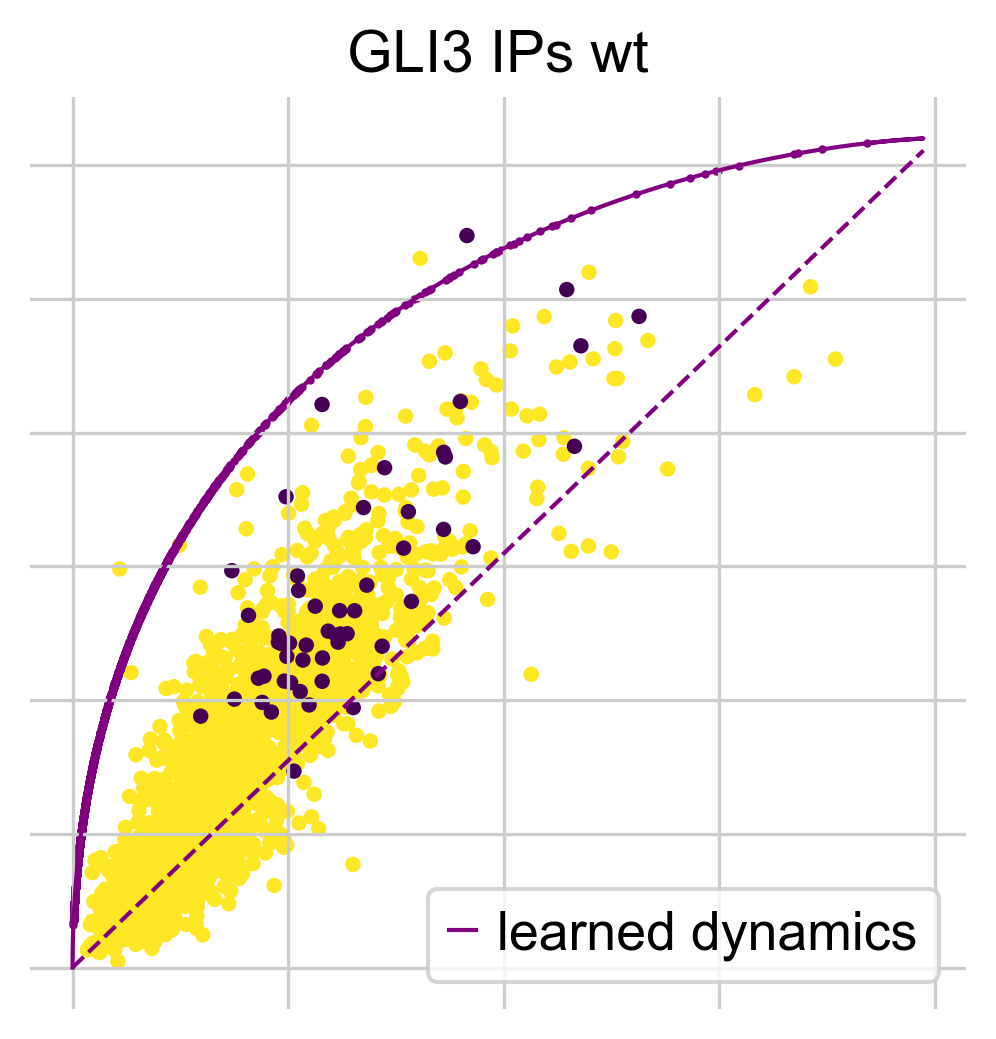

In [1418]:
##plot the velocity fittings of the found overlap in mut and wt - see whetere the velocity is low or high within the subset of 'bridge'

#scv.pl.scatter(ips_dict['mut'], basis='CENPF', ncols=5, frameon=False,color = masks_all['mut']['1'],dpi = 300,title='CENPF_IPs_mutant',colorbar=False)
#scv.pl.scatter(ips_dict['wt'], basis='CENPF', ncols=5, frameon=False,color = masks_all['wt']['1'],dpi = 300,title='EOMES_IPs_wt',colorbar=False)
scv.pl.scatter(ips_dict['wt'], basis='GLI3', ncols=5, frameon=False,color = masks_all['wt']['1'],dpi = 150,title='GLI3_IPs_wt',colorbar=False)

In [ ]:
genes = ['NFIB','ASPM','NNAT','SYNE2','CNTNAP2','CENPF','EOMES','NEUROD6']#EOMES

sc.pl.embedding(
        wt_all,
        basis="umap",
        color=genes,
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        #title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        #save = f'top_genes_{cond}_expression_nervous_system_development.pdf'
    )

sc.pl.embedding(
        mut_all,
        basis="umap",
        color=['NFIB','ASPM','NNAT','SYNE2','CNTNAP2','CENPF'],
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        #title = zip(genes_top_exp[cond], gene_exp_dict[cond][ind]),
        #save = f'top_genes_{cond}_expression_nervous_system_development.pdf'
    )

# mutatnt vs wt subset - last analysis 
here we look at how the gene expression

In [1042]:
terminal_state1 = ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal']
bridge = ips_dict['wt'][masks_all['wt']['1']]
end = ips_dict['wt'][masks_all['wt']['2']]

INP_mut = mut_all[mut_all.obs['cluster'] == 'IN Progenitor']

#ips_dict['wt'].obs['subset'][masks_all['wt']['1']] = 'bridge'
#ips_dict['wt'].obs['subset'][masks_all['wt']['2']] = 'DLN'
#ips_dict['wt'].obs['subset'][masks_all['wt']['3']] = 'terminal'
#ips_dict['wt'].obs['subset'][masks_all['wt']['4']] = 'start'


In [1048]:
overlapping_genes = list(set(INP_mut.var_names) & set(end.var_names))


np.corrcoef(terminal_state1[:, overlapping_genes].X.mean(axis = 0),INP_mut[:, overlapping_genes].X.mean(axis = 0))






array([[1.        , 0.96821257],
       [0.96821257, 1.        ]])

KeyError: 'Could not find key PTTG1 in .var_names or .obs.columns.'

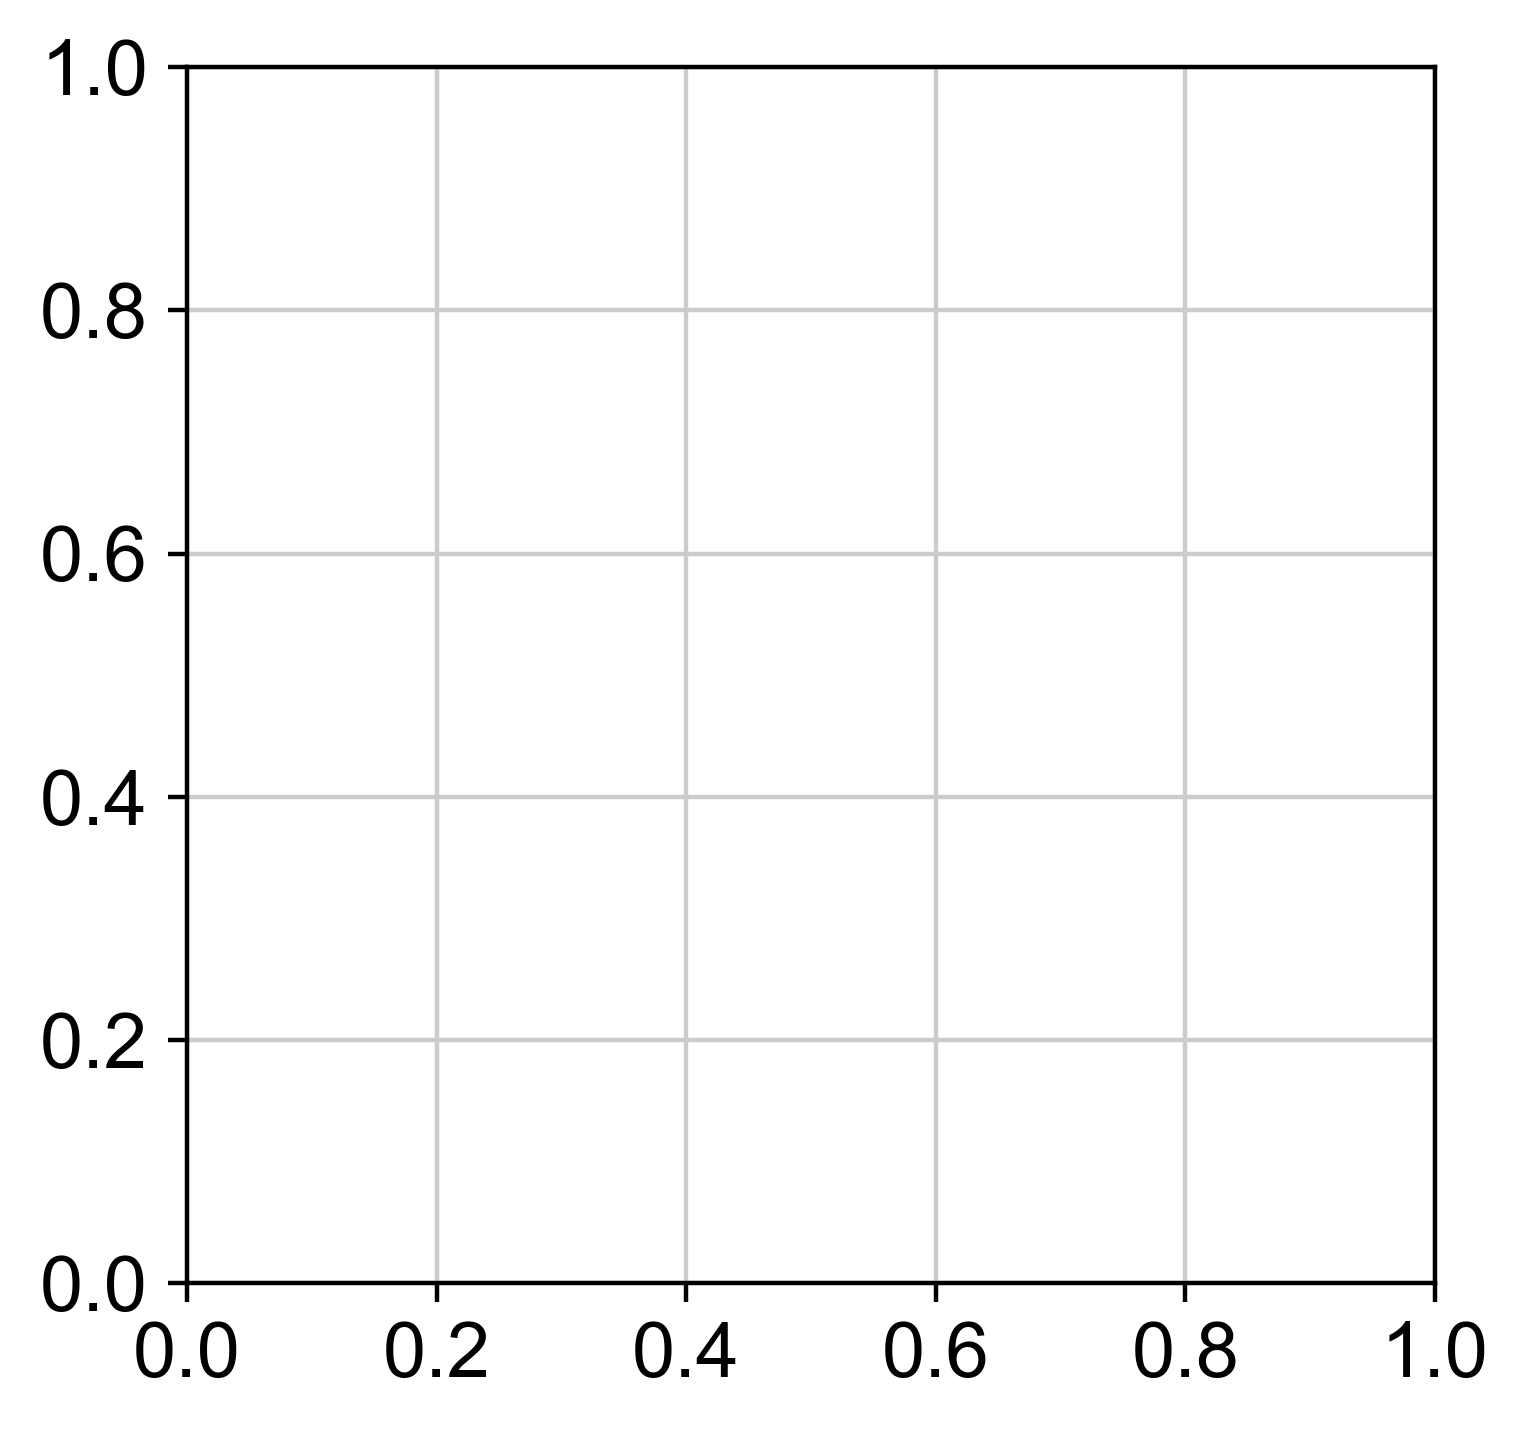

In [1223]:
 sc.pl.embedding(
        wt_all,
        size = 100.0,
        basis="umap",
        color='PTTG1',
        color_map="viridis",
        s=10,
        ncols=3,
        vmax="p96",
        title = 'Pax6 expression mut IPs',
        #save = f'PAX6_Exp_mut.pdf'
    )

[[1.         0.96821257]
 [0.96821257 1.        ]]


['STXBP6', 'NFIC', 'FYN', 'ELAVL4', 'IGFBPL1', 'ELAVL2']

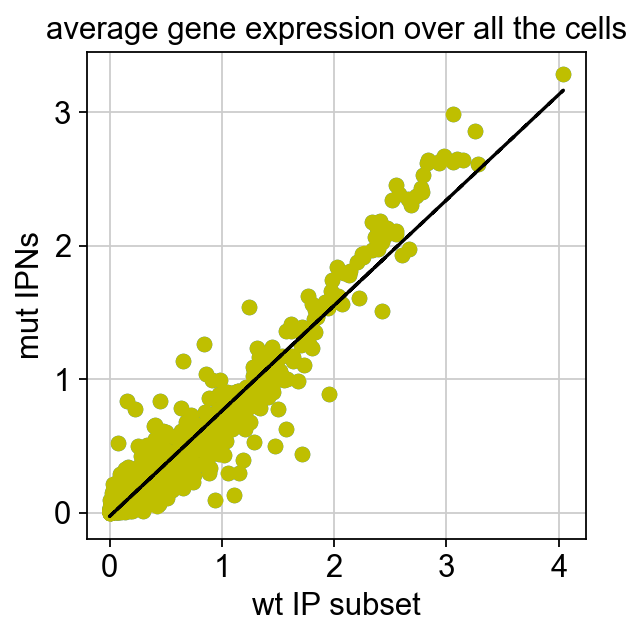

In [1058]:
x =  np.squeeze(np.asarray(terminal_state1[:, overlapping_genes].X.mean(axis = 0)))
#y = np.squeeze(np.asarray(end[:, overlapping_genes].X.mean(axis = 0)))

y = np.squeeze(np.asarray(INP_mut[:, overlapping_genes].X.mean(axis = 0)))
plt.scatter(x,y)

print(np.corrcoef(x,y))


coef = np.polyfit(x,y,1)
poly1d_fn = np.poly1d(coef) 


points = np.column_stack((x, y))
points,inside_bbox = points_inside_rectangle((1,0,1,0.5), points)


plt.plot(x,y, 'yo', x, poly1d_fn(x), '--k') #'--k'=black dashed line, 'yo' = yellow circle marker

plt.xlabel('wt IP subset')
plt.ylabel('mut IPNs')
plt.title('average gene expression over all the cells')
plt.savefig(path_main + '/gene_expression_mut_wt.png')




#le


list(terminal_state1[:,overlapping_genes][:,inside_bbox].var_names)




In [1189]:
brdige_v_term_df = pd.read_csv(path_main + '/data/brdige_v_term.csv',header=0,index_col = 0)
brdige_v_term_df[brdige_v_term_df.names == 'NFIC']
brdige_v_term_df[brdige_v_term_df.names == 'STXBP6']
brdige_v_term_df[brdige_v_term_df.names == 'TAGLN3']
brdige_v_term_df[brdige_v_term_df.names == 'NDUFC2']
brdige_v_term_df[brdige_v_term_df.names == 'ENC1'] ##genes which are both: more differently expressed in the 'bridge' and the mutant 




start_v_term_df = pd.read_csv(path_main + '/data/start_v_term.csv',header=0,index_col = 0)

DLN_v_term_df =  pd.read_csv(path_main + '/data/DLN_v_term.csv',header=0,index_col = 0)




set(start_v_term_df.nlargest(10,'scores').names.values) & set(start_v_term_df.nlargest(10,'scores').names.values)

print(*list(start_v_term_df[(start_v_term_df['pvals_adj'] <= 0.05) & (start_v_term_df['scores'] >= 0)].names.values), sep = '\n')



VIM
RPS27A
RPS8
RPS14
HES6
RPL34
RPL5
RPS18
RPL24
RPL35A
RPS2
HSP90AB1
RPL12
RPS12
RPL3
NACA
RPL6
DLL1
RPL19
RPS24
RPS19
RPL13A
BTG1
RPS27
RPS6
RPL10A
RPL11
RPL29
HES5
NPM1
RPL36
RPL37
RPL28
RPLP0
RPL13
RPL10
FTL
MIR9-1HG
DOK5
RPL32
RPL23
CCND1
EEF2
RPS23
RPL7A
RPL37A
TPT1
RPLP1
RPS28
RPL27A
NDUFC2
EIF3E
RPS15A
RACK1
RPL30
HMGCS1
BTF3
NEUROG2
RPS29
SVIL
RPS7
RPS5
COL11A1
RPL14
RPS9
RPS3A
MYCL
RPL31
RPS16
TFDP2
RPL7
SNHG16
RPL35
RPS26
RPL8
TMEM158
GAS5
MYO10
RPL9
RPS15
RPL18
RPL21
RPL18A
RSL1D1
RPL22
MT-ND3
RPS13
RPSA
RPL38
BAZ2B
RPS11
MARCKSL1
RPL4
BTG2
REXO2
RPS3
HES1
MT-RNR2
RPL23A
SRP14
PPA1
EIF3H
EEF1A1
CBFA2T2
STK17A
DHX40
GADD45GIP1
PRAG1
TOMM7
SSB
MDFI
FEZF2
OST4
TSPO
MPST
CKB
ATP5MC2
BCL7A
CREB5
MAGI1
TFAP2C
SOX4
COMMD6
FGFBP3
APEX1
ATP2B2
COX7C
HSPE1
TMEM161B-AS1
DDX5
TOX3
UQCRB
RPS27L
EEF1D
GLUL
RGS16
RPS4X
MT-RNR1
HNRNPC
ACTR3B
CCND2
TOMM20
SNRPGP10
PBXIP1
ST13
EIF4B
SETBP1
RPL36A
RRP15
RPL27
C4orf3
H1-0
RPS25
SINHCAF
SLC25A3
ATP1B3
NIFK
ZKSCAN1
CELSR1
SSBP3
AAMDC
ZC3H12C
RP

In [1423]:
print(DLN_v_term_df[DLN_v_term_df.names == 'GLI3'])

print(start_v_term_df[start_v_term_df.names == 'GLI3'])

print(DLN_v_term_df[DLN_v_term_df.names == 'FOXP1'])

print(start_v_term_df[start_v_term_df.names == 'FOXP1'])

print(DLN_v_term_df[DLN_v_term_df.names == 'HES4'])

print(start_v_term_df[start_v_term_df.names == 'HES4'])

print(DLN_v_term_df[DLN_v_term_df.names == 'HES5'])

print(start_v_term_df[start_v_term_df.names == 'HES5'])

print(DLN_v_term_df[DLN_v_term_df.names == 'SOX11'])

print(start_v_term_df[start_v_term_df.names == 'SOX11'])

print(DLN_v_term_df[DLN_v_term_df.names == 'OTX2'])

print(start_v_term_df[start_v_term_df.names == 'OTX2'])

print(DLN_v_term_df[DLN_v_term_df.names == 'ANP32E'])

print(start_v_term_df[start_v_term_df.names == 'ANP32E'])


print(DLN_v_term_df[DLN_v_term_df.names == 'SOX4'])

print(start_v_term_df[start_v_term_df.names == 'SOX4'])

print(DLN_v_term_df[DLN_v_term_df.names == 'FOXG1'])

print(start_v_term_df[start_v_term_df.names == 'FOXG1'])

print(DLN_v_term_df[DLN_v_term_df.names == 'HES1'])

print(start_v_term_df[start_v_term_df.names == 'HES1'])

print(DLN_v_term_df[DLN_v_term_df.names == 'BATF3'])

print(start_v_term_df[start_v_term_df.names == 'BATF3'])
 





      names    scores  logfoldchanges         pvals     pvals_adj
60127  GLI3 -11.45775       -1.278735  1.169641e-28  9.627557e-27
    names    scores  logfoldchanges     pvals  pvals_adj
239  GLI3  4.564383        0.684459  0.000008   0.000328
       names    scores  logfoldchanges         pvals     pvals_adj
59695  FOXP1 -7.891932       -1.494881  8.835449e-15  3.812188e-13
     names   scores  logfoldchanges     pvals  pvals_adj
380  FOXP1  3.40813        0.802337  0.000768   0.020523
      names     scores  logfoldchanges         pvals     pvals_adj
60187  HES4 -12.426414       -1.185002  3.473821e-33  3.287611e-31
      names    scores  logfoldchanges         pvals     pvals_adj
60030  HES4 -6.551972       -1.036607  2.603848e-10  2.040825e-08
      names    scores  logfoldchanges         pvals     pvals_adj
60328  HES5 -15.37772       -4.143759  5.548682e-45  7.598313e-43
   names     scores  logfoldchanges         pvals     pvals_adj
28  HES5  13.888611        2.648188  6.02850

In [1392]:
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'start'][:,'GLI3'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal'][:,'GLI3'].X.mean())

print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'bridge'][:,'GLI3'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'None'][:,'GLI3'].X.mean())

print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'DLN'][:,'GLI3'].X.mean())


print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'start'][:,'FOXP1'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal'][:,'FOXP1'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'DLN'][:,'FOXP1'].X.mean())


print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'start'][:,'HES4'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal'][:,'HES4'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'DLN'][:,'HES4'].X.mean())


print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'start'][:,'HES1'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal'][:,'HES1'].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'DLN'][:,'HES1'].X.mean())

DLX5


'''



LRRN1
SVIL
ADAMTS9
ANGPTL1
MYCL
DAB1
HSPE1
NDUFAF8

H3C13
CDYL
RCC1
DDX12P
TOP2A
CDC25C
VPS29
FANCE
MANEA
TULP3
TAF1B


'''

0.77798295
0.5495209
0.412423
0.41356328
0.26380402
0.37406996
0.2312113
0.088281125


KeyError: 'HES4'

In [1207]:
print(*list(set(start_v_term_df[(start_v_term_df['pvals_adj'] <= 0.05) & (start_v_term_df['scores'] <= 0)].names.values) & set(brdige_v_term_df[(brdige_v_term_df['pvals_adj'] <= 0.05) & (brdige_v_term_df['scores'] >= 0)].names.values)), sep = '\n')

C12orf57
ATP5F1B
GPM6A
FLRT3
CALM3
PTTG1
SOX11
DYNLL1
RNF5
HDAC2
HSP90B1
LSM5
HDGF
DCXR
SET
CCNA1
GNAS
PTMS
UBE2S
SLCO5A1
TUBA1A
SRP9
FJX1
MYL12B
DDAH2
TMSB10
MEIS3
ENC1
ACTB
DPYSL2
SEPHS1
SMIM14
NHLH1
CD24
DCTN3
JAKMIP2
NEUROD6


In [1347]:
print(*list(set(start_v_term_df[(start_v_term_df['pvals_adj'] <= 0.05) & (start_v_term_df['scores'] <= 0)].names.values) & set(brdige_v_term_df[(brdige_v_term_df['pvals_adj'] <= 0.05) & (brdige_v_term_df['scores'] <= 0)].names.values)), sep = '\n')

H3C13
CDYL
RCC1
DDX12P
TOP2A
CDC25C
VPS29
FANCE
MANEA
TULP3
TAF1B
CFAP20
C2CD5
KCNK3
TUBA1C
NKTR
C19orf48
PIEZO2
SKA1
H2AC21
DYNLT2B
DLGAP5
NEIL3
H2BC14
SSRP1
PCNA
NEDD1
EPS8
DNAJC1
RDX
MARCHF1
BUB1
YEATS4
CHAF1B
CEP135
PSMC3IP
H2AC4
DESI2
ANKRD36C
UPF3B
H1-2
NSL1
HMGB2
SLC4A8
H2AC14
PSRC1
EXOSC9
PHTF2
G2E3
H2AC17
CENPQ
CKAP2
ZNF672
IQGAP3
B4GALNT1
HJURP
ADD3
H4C5
AP2S1
RAP1GAP2
POLA1
FANCI
PTBP1
CDH11
H2BC5
TEDC1
FKBP5
ENSG00000287731
HSPB11
GUSB
PARPBP
UBE2V1P13
RBBP4
SFRP2
TMEM245
H2BC9
NSMCE4A
FGF12
PSMD1
KCNAB3
XRCC3
ARHGAP11A
TRA2B
HNRNPUL1
RFX3
PTPRE
CDCA2
AURKB
PSAT1
CENPK
GPX8
RASAL2
ENSG00000272501
RANBP1
ENOSF1
DHRS13
HELLPAR
H1-4
DEPDC1B
UBE2C
INSR
BLM
BTRC
MGME1
H2BC10
KIF14
SLITRK2
RBBP8
H2BC3
ZWINT
NEK2
KNTC1
ING1
CTDSPL2
ASCL1
TFDP1
PIGCP1
ASF1B
PKNOX1
ITPRIPL1
NHLH2
MIS12
ICMT
H4C8
BUB1B
RBL1
RIF1
WEE1
USP31
CENPC
ENSG00000237753
HNRNPD
IKBIP
OIP5
NCAPG2
SHMT1
NUDT15
BRIP1
DSN1
EED
PLCH1
NTAN1
RTTN
SMC5
MAPK1
H4C6
H2BC13
STXBP5L
DHTKD1
RASSF7
NSD3
ENSG00000273014
MLH1


In [1359]:
print(*list(set(start_v_term_df[(start_v_term_df['pvals_adj'] <= 0.05) & (start_v_term_df['scores'] >= 0)].names.values) & set(brdige_v_term_df[(brdige_v_term_df['pvals_adj'] <= 0.05) & (brdige_v_term_df['scores'] >= 0)].names.values)), sep = '\n')

RPL6
RPS11
RPL35A
ATP6V1G1
ZNF121
RPS14
SOX4
RPL19
HSPE1
COX7C
SNHG19
HNRNPK
RBM3
MIR9-1HG
MYO10
ODC1
TSPO
BASP1
RPL14
BTBD17
MARCKSL1
SAT2
MT-CO3
HNRNPC
BTF3
CSTB
EIF3G
RPL34
HMGCS1
RPL5
UQCRB
MT-ATP6
MXI1
COMMD6
RGS16
KDM1A
RPS7
MT-CO1
EZR
MT-ND3
RPL24
EIF1B
RPS27
TMA7
ENSG00000283103
RPL11
SEC61G
SRSF5
RPL21
FABP7
LINC01315
MT-CYB
SKP1
FTL
SSR2
IGFBP2
RPL23
DHX36
SRP14
DDX5
MT-CO2
TIMM8B
MT-RNR1
RPS8
MT-RNR2
HSP90AB1
NIFK
PAK1IP1
NACA
NDUFS5
UQCRC2
RPL30
RRP15
RPS27L
EIF3H
RPS27A
RPS26
TOMM20
SUB1
STRAP
RACK1


In [1388]:
print(*list(set(start_v_term_df[(start_v_term_df['pvals_adj'] <= 0.05) & (start_v_term_df['scores'] <= 0)].names.values) & set(DLN_v_term_df[(DLN_v_term_df['pvals_adj'] <= 0.05) & (DLN_v_term_df['scores'] <= 0)].names.values) ), sep = '\n')

GUCD1
CDYL
RCC1
H3C13
TMTC3
ACOT7
TOP2A
PRR11
INIP
IFT122
IRF2BP1
ANP32A
PIEZO2
SKA1
SP1
CEP20
H2AC4
ANKRD36C
JMJD8
HMGB2
SLC4A8
RNF26
CCDC138
INO80E
TTL
G2E3
CENPQ
GPX4
NDUFV1
ADD3
H4C5
FKBP5
PRKD3
HSPB11
PARPBP
SFRP2
CBX3
NCAPD2
HNRNPUL1
RNF126
H1-4
HSPA13
CEP131
H2BC10
KIF14
CCNB2
TFDP1
ASF1B
SMTN
PKNOX1
H4C8
BUB1B
ACADVL
MAGEF1
EAF2
TRIR
NCAPG2
SUMO3
SMC5
MAPK1
H2BC13
ENSG00000273014
MLH1
UBE2I
MTF2
TMEM138
SRR
NT5M
FANCL
CDC6
GINS1
SPATA5
BRD8
ENSG00000251188
ENSG00000267383
POLE
CENPN
NEUROD4
SKP2
ANKLE2
LMNB2
BTG3
ZNF273
HES4
RFC4
FBXO45
TRIP13
PDK3
DERL2
RANGAP1
SFMBT1
KIF18B
MAGI3
DUT
FUBP1
RAD21
MIS18BP1
PRC1-AS1
CDK2
TMEM203
ENSG00000284610
RNU2-17P
MDFIC
PARP1
CCDC14
FAM72B
TCERG1
EEF2K
H2AC6
FZR1
HMGN1
SRGAP2B
USP48
RFWD3
UBAC1
TEX30
NASP
CNTROB
FAM72C
ITGAE
CEP152
GAPDH
DCLRE1B
HAUS1
SIRPA
CCND3
PLK1
DPP9
XRCC2
SYNC
LMAN1
SMCHD1
PIDD1
GMNN
ERCC6L
GNG4
CDCA4
HNRNPA3
ING2
ZNF92
COPS3
SRSF4
UTRN
KNSTRN
HDGFL3
KANTR
CMC2
FOXRED1
LRR1
BDH1
TEDC2
CBLN1
PM20D2
PRTFDC1
ARRB2
SPC2

In [1233]:
for subs in masks_all['mut']:
    print(sum(masks_all['mut'][subs]))
    print(subs)

20
1
114
2
133
3
29
4
296
and


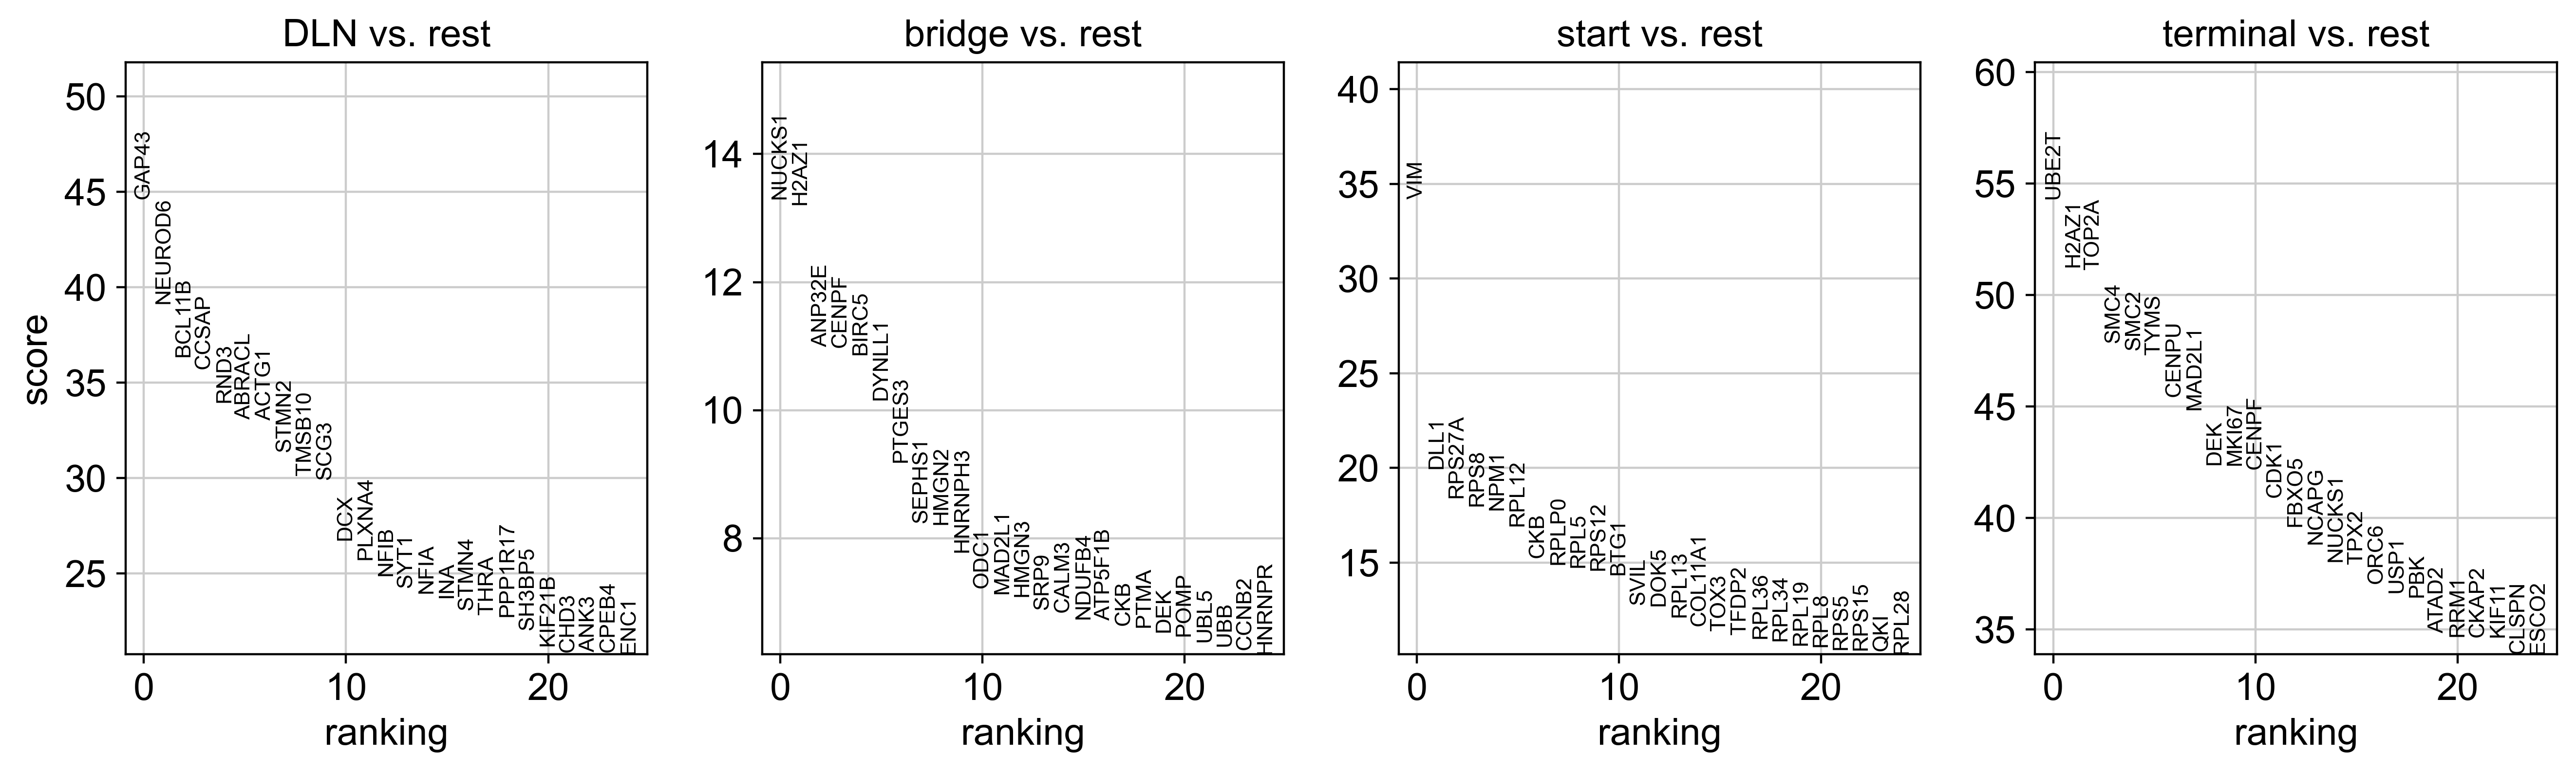

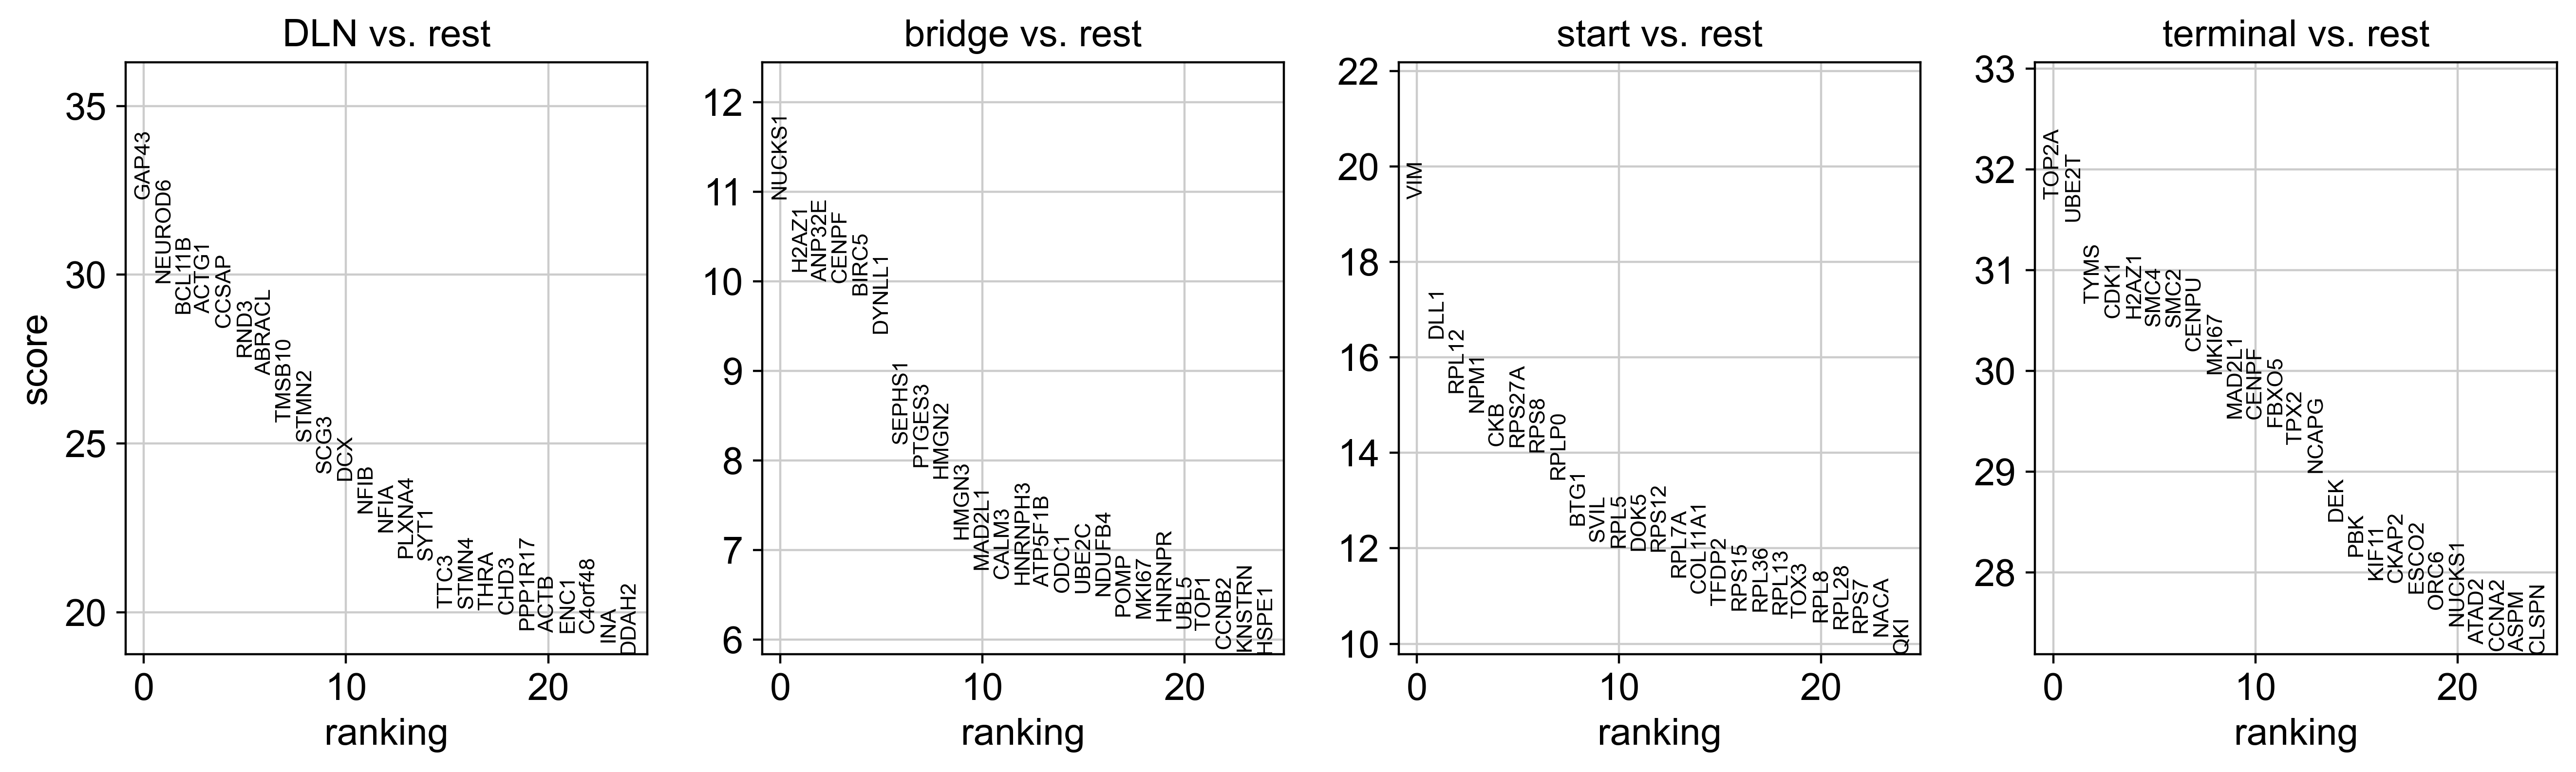

In [1234]:
sc.tl.rank_genes_groups(ips_dict['wt'], 'subset', method='t-test',key_added='expression_ttest')
sc.tl.rank_genes_groups(ips_dict['wt'], 'subset', method='t-test',key_added='velocity_ttest')
sc.tl.rank_genes_groups(ips_dict['wt'], 'subset', method='wilcoxon',key_added='expression_wilcoxon')



sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False, key = "expression_ttest")
sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False, key = "expression_wilcoxon")

#sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False, key = "velocity_ttest")



In [1424]:
#sc.tl.rank_genes_groups(ips_dict['wt'], 'subset',reference = 'terminal', method='wilcoxon',key_added='expression_wilcoxon_terminal')


sc.tl.rank_genes_groups(ips_dict['wt'], 'subset',reference = 'DLN', method='t-test',key_added='expression_ttest_end')
#sc.tl.rank_genes_groups(ips_dict['wt'], 'subset',reference = 'DLN', method='t-test',key_added='expression_ttest_end')


df_tvalues_start_v_DLN_ttest = sc.get.rank_genes_groups_df(ips_dict['wt'],'start',key = 'expression_ttest_end')
df_tvalues_start_v_DLN_ttest

#df_tvalues_DLN_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'DLN',key = 'expression_ttest_end')
#df_tvalues_bridge_v_term = sc.get.rank_genes_groups_df(ips_dict['wt'],'bridge',key = 'expression_ttest_end')

#df_tvalues_bridge_v_term.to_csv(path_main + '/data/brdige_v_term.csv')
#df_tvalues_DLN_v_term.to_csv(path_main + '/data/DLN_v_term.csv')
#df_tvalues_start_v_term.to_csv(path_main + '/data/start_v_term.csv')

#sc.tl.rank_genes_groups(ips_dict['wt'], 'subset', method='wilcoxon',key_added='expression_wilcoxon')



#sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False, key = "expression_ttest")
#sc.pl.rank_genes_groups(ips_dict['wt'], n_genes=25, sharey=False, key = "expression_wilcoxon")

names     scores  logfoldchanges          pvals      pvals_adj
0         VIM  41.311390        4.370368  6.004505e-108  1.056793e-105
1        DLL1  24.440567        3.870944   1.314564e-61   7.712108e-60
2        NPM1  20.951073        1.498612   1.044263e-59   5.776266e-58
3         CKB  19.757170        1.315923   2.207675e-52   8.904290e-51
4      RPS27A  17.152296        0.599735   7.824699e-47   2.754294e-45
...       ...        ...             ...            ...            ...
1931   BCL11B -33.861149       -3.498701  2.554776e-103  4.121706e-101
1932     SCG3 -39.082882       -5.726653  1.823077e-210  3.529477e-207
1933    CCSAP -39.191010       -4.183146  2.751557e-136  1.065403e-133
1934    GAP43 -44.117725       -4.322219  5.448735e-144  2.637188e-141
1935  NEUROD6 -47.882507       -5.247014  2.573574e-174  2.491219e-171

[1936 rows x 5 columns]

In [1446]:
sc.settings.figdir = path_plot
#sc._settings.ScanpyConfig(figdir='/')

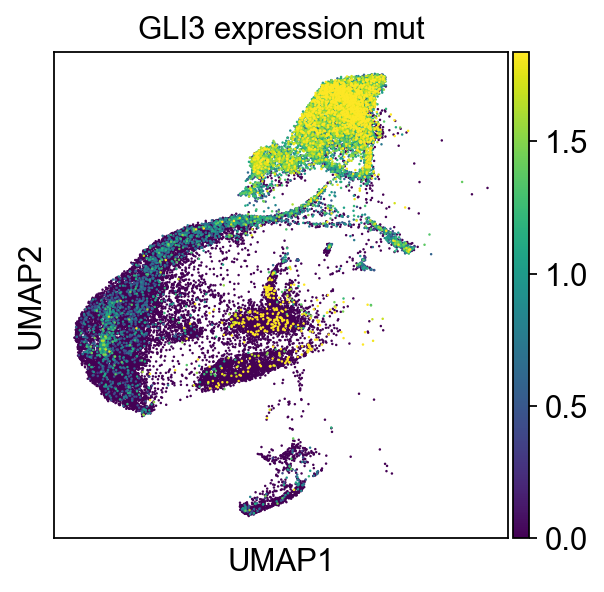

KeyError: 'Could not find key SOX4 in .var_names or .obs.columns.'

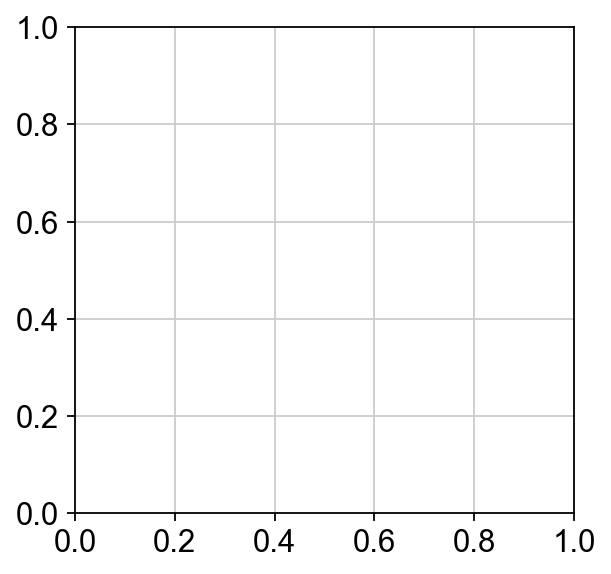

In [1454]:
##11/12/23

sc.tl.rank_genes_groups(ips_dict['wt'], 'subset',reference = 'DLN', method='t-test',key_added='expression_ttest_end')
df_tvalues_start_v_DLN_ttest = sc.get.rank_genes_groups_df(ips_dict['wt'],'start',key = 'expression_ttest_end')

sc.set_figure_params(dpi_save=300)

#df_tvalues_start_v_DLN_ttest.to_csv(path_main + '/data/df_tvalues_start_v_DLN_ttest.csv')

wt_mut = [wt_all,mut_all]
wt_mut_strings = ['wt', 'mut']
genes = ['GLI3', 'SOX4', 'HES4','SOX11']

for name_i, wt_mut in enumerate(wt_mut):
    for gene in genes:
        sc.pl.embedding(
            wt_mut,
            size = 100,
            basis="umap",
            color=gene,
            color_map="viridis",
            s=5,
            ncols=3,
            vmax="p96",
            title = f'{gene} expression {wt_mut_strings[name_i]}',
            save =  f'/{gene}_Exp_{wt_mut_strings[name_i]}.png'
        )


In [1164]:
df_tvalues_bridge_v_term_vel = sc.get.rank_genes_groups_df(ips_dict['wt'],'bridge',key ='velocity_ttest')

df_tvalues_bridge_v_term_vel[df_tvalues_bridge_v_term_vel.names == 'EOMES']


names    scores  logfoldchanges     pvals  pvals_adj
295  EOMES  1.477629        0.171738  0.141622   0.299136

Genes found differene between IP progneitors mut and IPs wt: LAPTNAA, EMX1, NFIC, GADD45G, PSMD14, ELAVL4, ELAVL2, IGFBPL1,STXBP6,PHLDA1,TAGLN3,NDUFC2,EOMES,FYN,ENC1

/Users/samuelheczko/anaconda3/envs/scvelo/lib/python3.11/site-packages/scanpy/plotting/_tools/__init__.py:1199: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ax.set_xticklabels(new_gene_names, rotation='vertical')


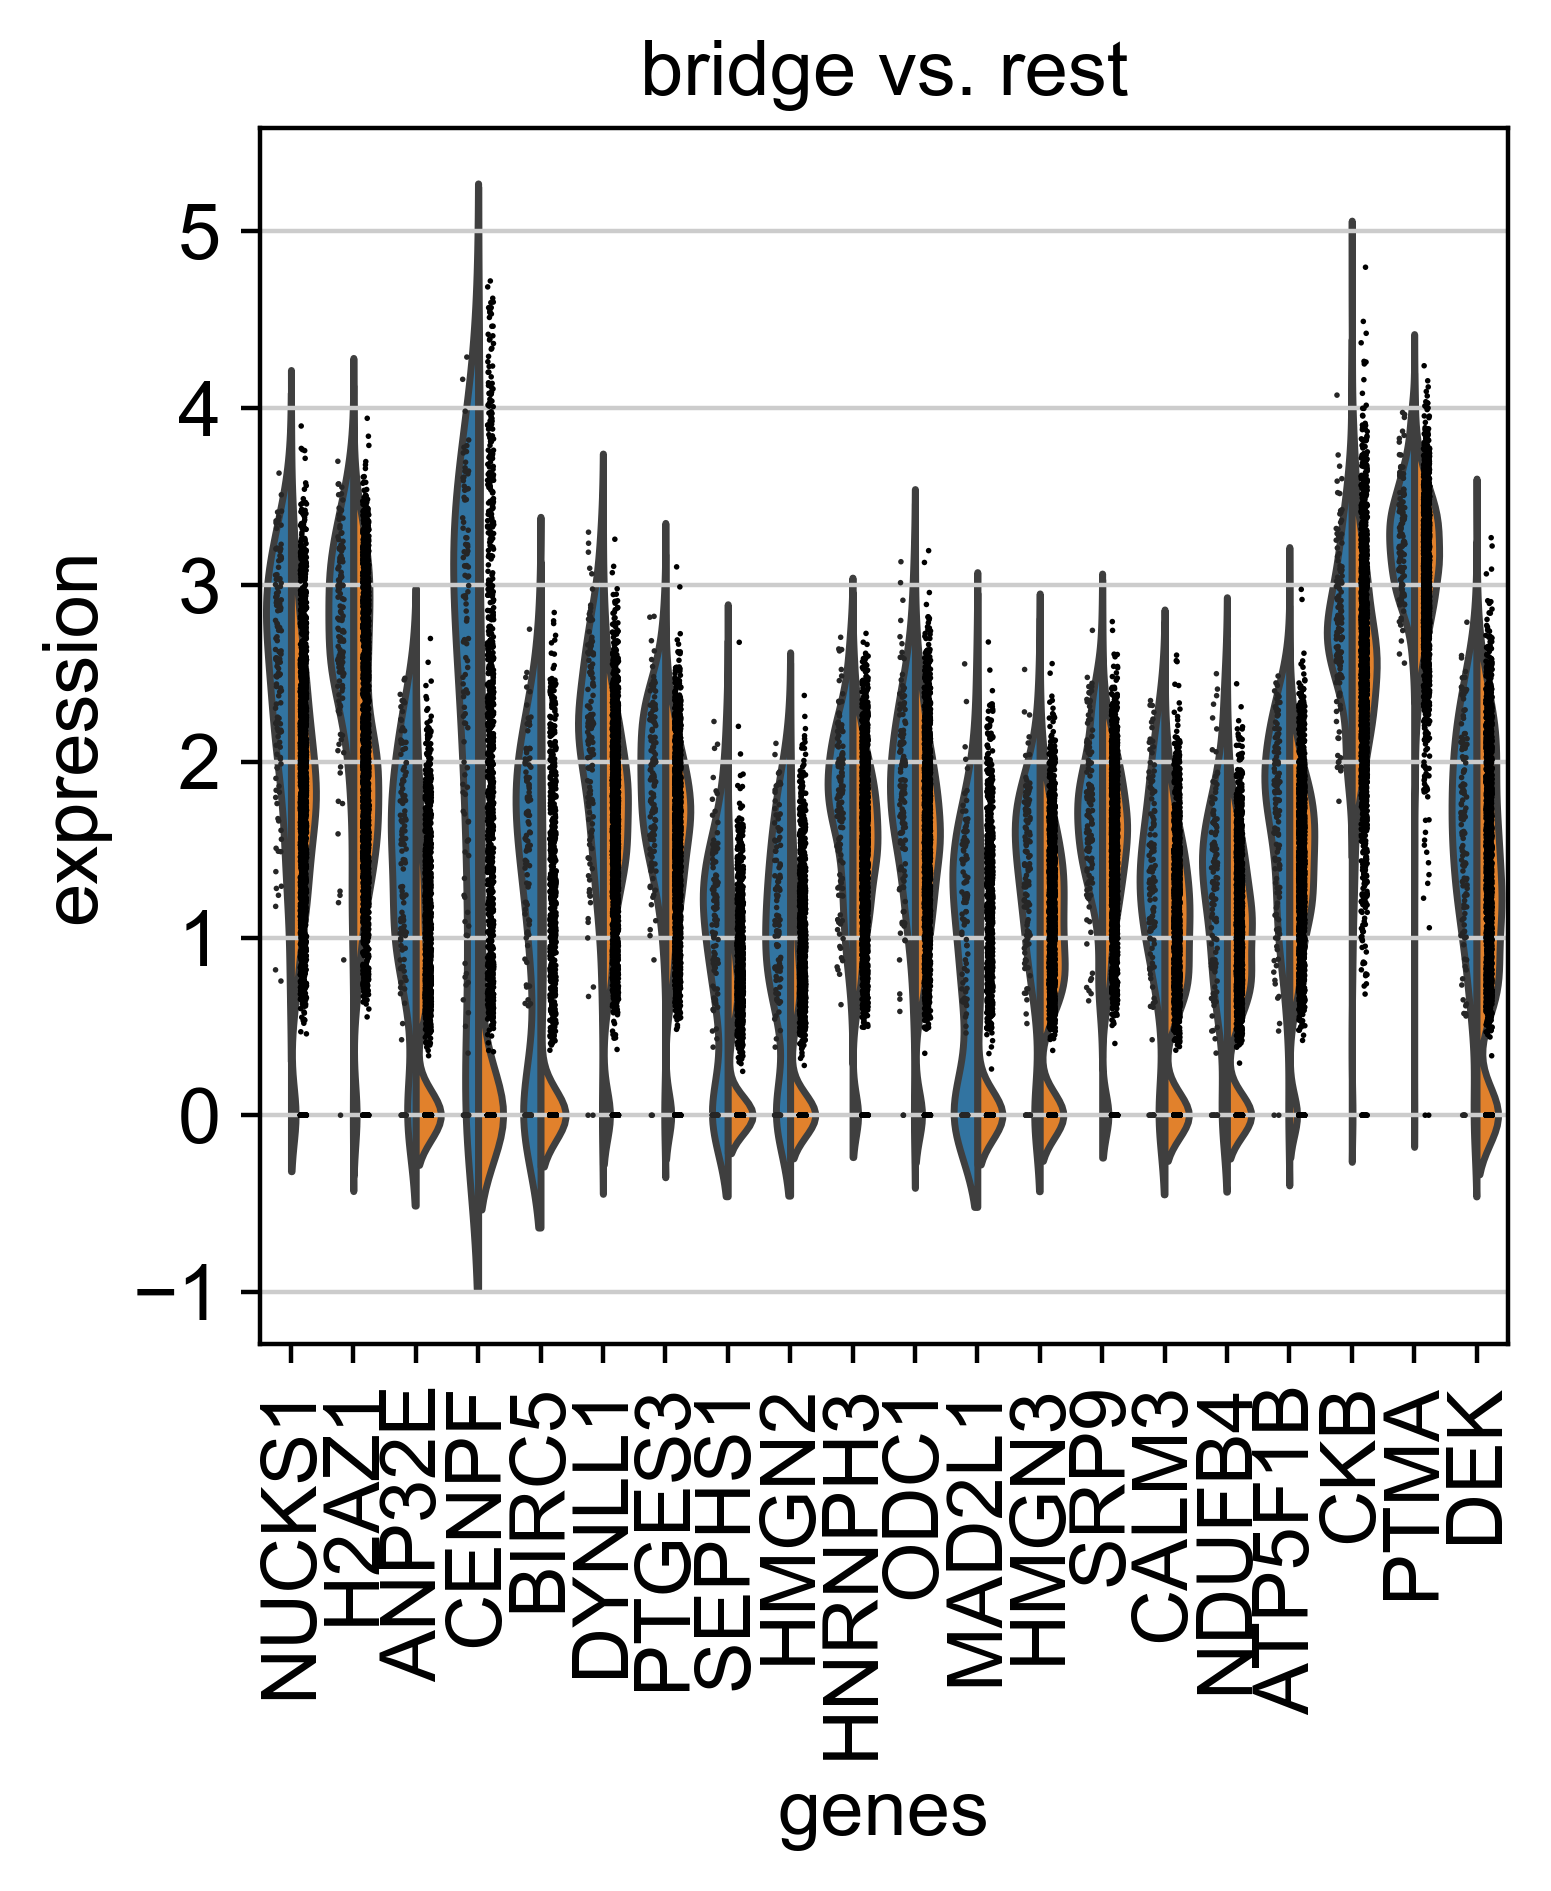

In [1225]:
df_tvalues_bridge_v_term_vel = sc.get.rank_genes_groups_df(ips_dict['wt'],'bridge',key ='velocity_ttest')

df_tvalues_bridge_v_term_vel

sc.pl.rank_genes_groups_violin(ips_dict['wt'], groups='bridge', n_genes=20,key = 'expression_ttest')


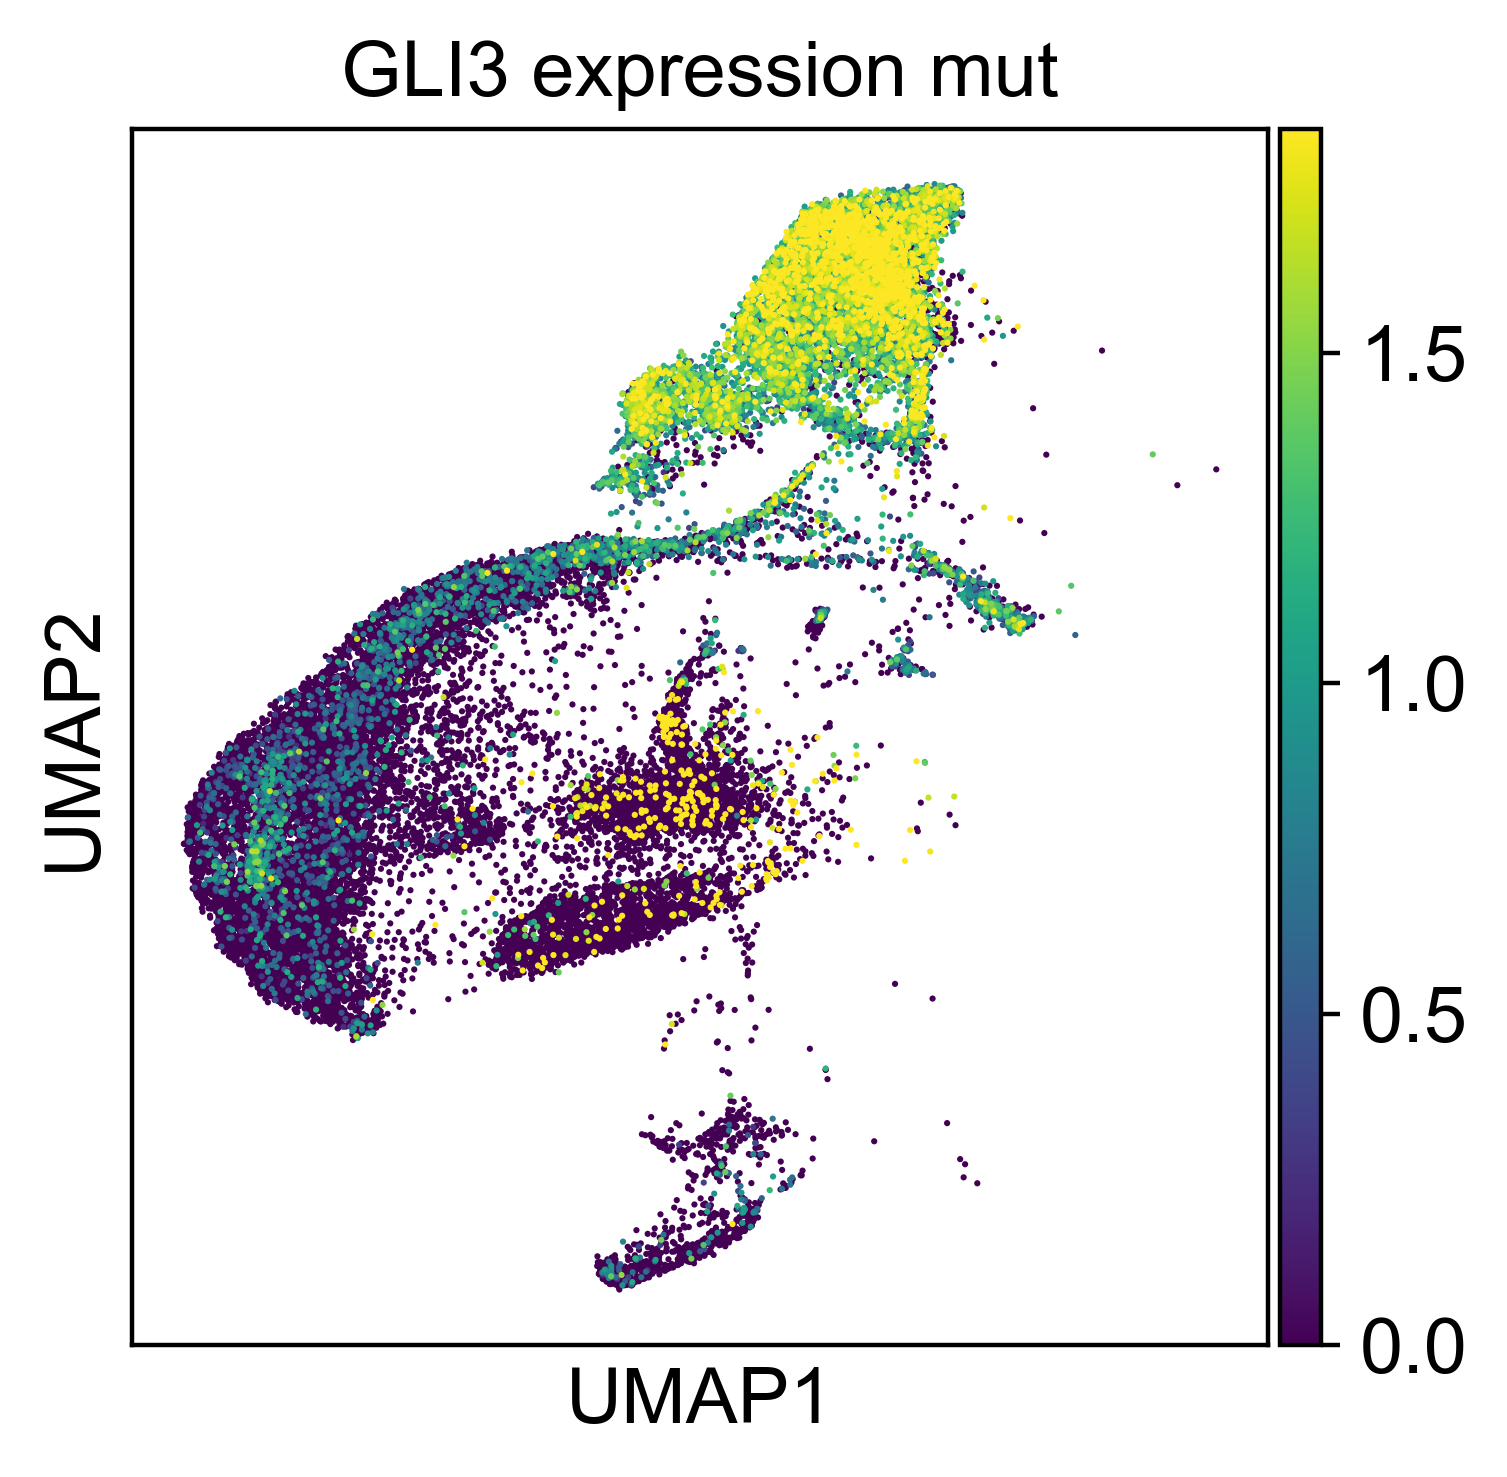

[[1.         0.50623265]
 [0.50623265 1.        ]]
[[1.         0.23436724]
 [0.23436724 1.        ]]


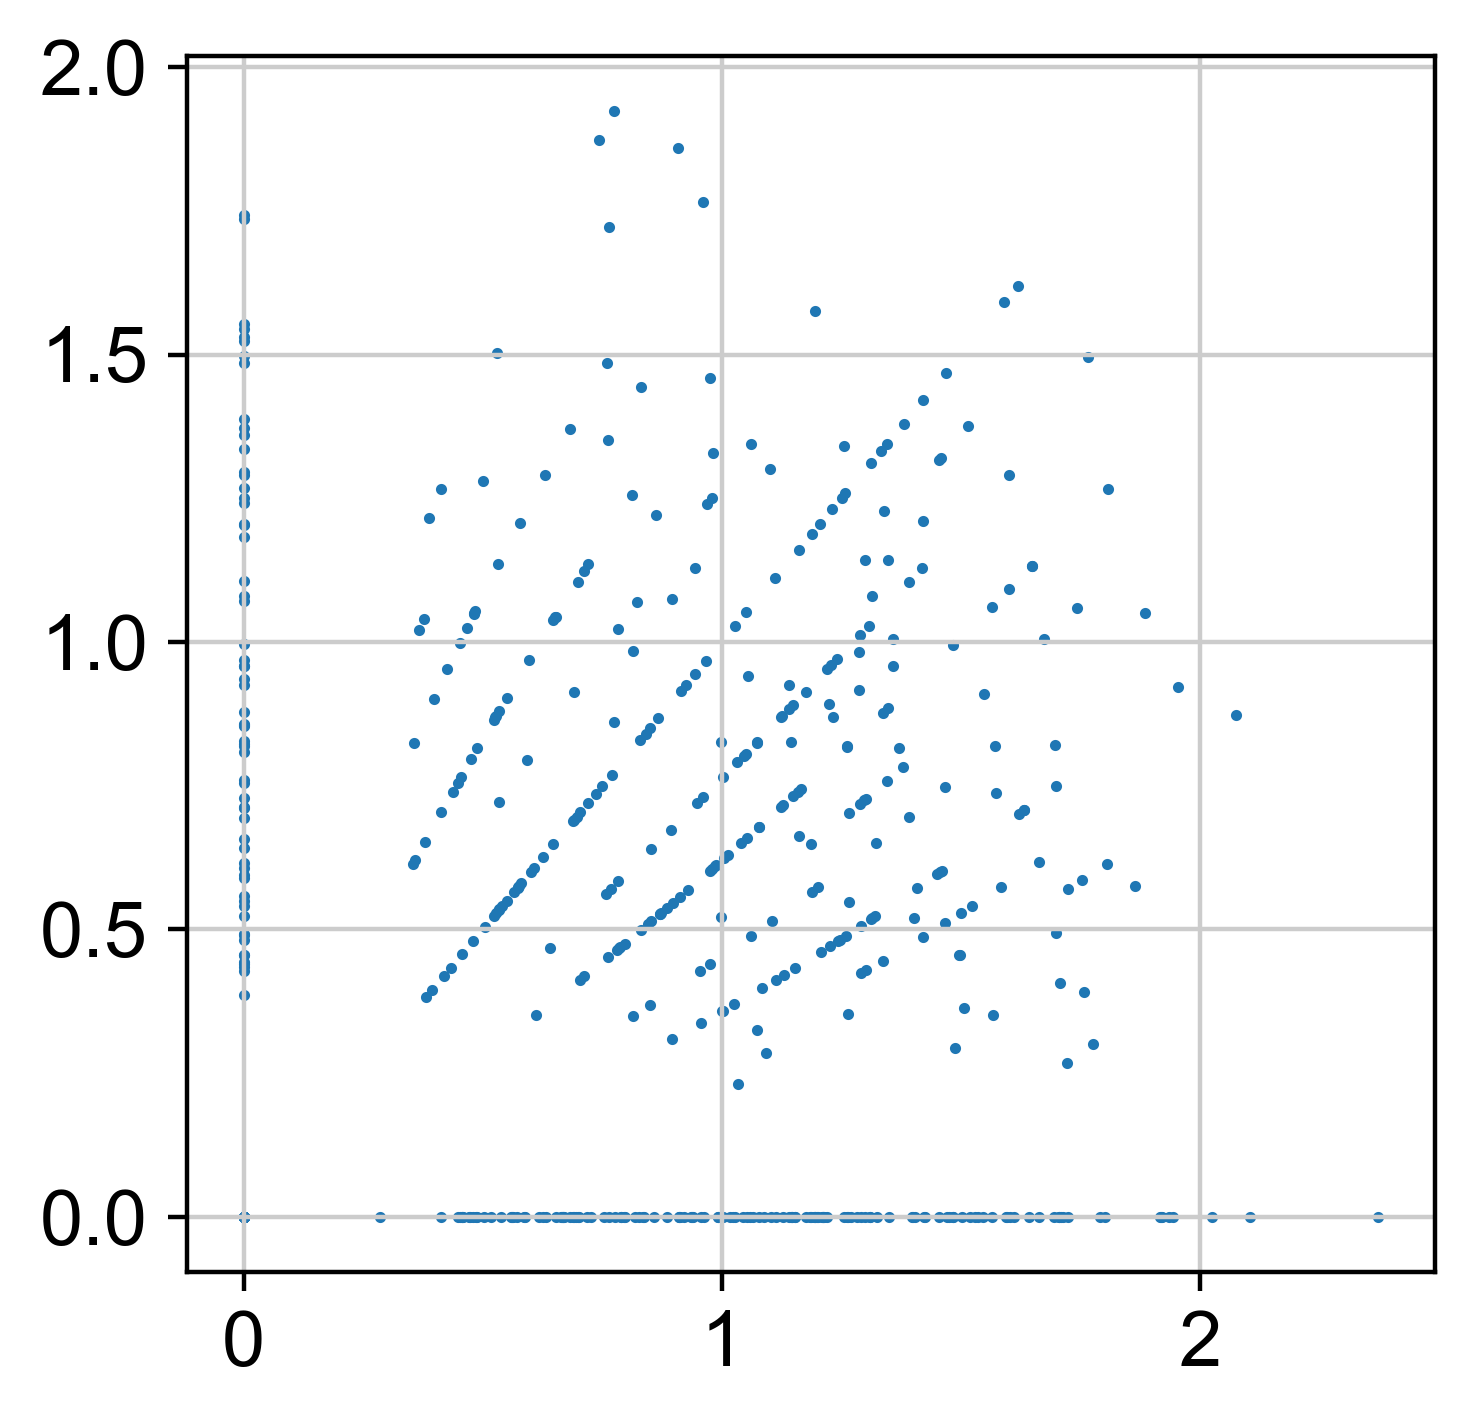

IndexError: Unknown indexer AnnData object with n_obs × n_vars = 46204 × 1889
    obs: 'Clusters', '_X', '_Y', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'cluster'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr', 'fit_r2', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_', 'fit_scaling', 'fit_std_u', 'fit_std_s', 'fit_likelihood', 'fit_u0', 'fit_s0', 'fit_pval_steady', 'fit_steady_u', 'fit_steady_s', 'fit_variance', 'fit_alignment_scaling', 'velocity_genes'
    uns: 'log1p', 'neighbors', 'pca', 'recover_dynamics', 'velocity_graph', 'velocity_graph_neg', 'velocity_params', 'cluster_colors', 'rank_genes_groups'
    obsm: 'X_pca', 'X_umap', 'velocity_umap'
    varm: 'PCs', 'loss'
    layers: 'Ms', 'Mu', 'ambiguous', 'fit_t', 'fit_tau', 'fit_tau_', 'matrix', 'spliced', 'unspliced', 'velocity', 'velocity_u'
    obsp: 'connectivities', 'distances' of type <class 'anndata._core.anndata.AnnData'>

In [1409]:
 sc.set_figure_params(scanpy=True, dpi=200)
 
 gene = 'GLI3'

 sc.pl.embedding(
        wt_all,
        size = 100.0,
        basis="umap",
        color=gene,
        color_map="viridis",
        s=5,
        ncols=3,
        vmax="p96",
        title = f'{gene} expression mut',
        #save = path_plot + f'/{gene}_Exp_mut.png'
    )

print(np.corrcoef(np.squeeze(np.asarray(wt_all[:,['PAX6']].X.mean(axis= 1))),np.squeeze(np.asarray(wt_all[:,['GLI3']].X.mean(axis= 1)))))
print(np.corrcoef(np.squeeze(np.asarray(mut_all[:,['PAX6']].X.mean(axis= 1))),np.squeeze(np.asarray(mut_all[:,['GLI3']].X.mean(axis= 1)))))


#ips_dict['wt'][:,['PAX6']].X.shape


plt.scatter(np.squeeze(np.asarray(ips_dict['wt'][masks_all['wt']['3'],['PAX6']].X.mean(axis= 1))),np.squeeze(np.asarray(ips_dict['wt'][masks_all['wt']['3'],['GLI3']].X.mean(axis= 1))),s = 1)
plt.show()

#plt.scatter(np.squeeze(np.asarray(ips_dict['mut'][:,['PAX6']].X.mean(axis= 1))),np.squeeze(np.asarray(ips_dict['mut'][:,['GLI3']].X.mean(axis= 1))))


plt.scatter(np.squeeze(np.asarray(mut_all[mut_all,['PAX6']].X.mean(axis= 1))),np.squeeze(np.asarray(mut_all[:,['GLI3']].X.mean(axis= 1))),s = 1)
plt.show()
plt.scatter(np.squeeze(np.asarray(wt_all[:,['PAX6']].X.mean(axis= 1))),np.squeeze(np.asarray(wt_all[:,['GLI3']].X.mean(axis= 1))),s = 1)





In [1386]:
print(mut_all[mut_all.obs.cluster == 'IN Progenitor',['GLI3']].X.mean())
print(ips_dict['wt'][ips_dict['wt'].obs['subset'] == 'terminal'][:,'GLI3'].X.mean())



0.39542523
0.5495209


In [1284]:
np.squeeze(np.asarray(ips_dict['wt'][masks_all['wt']['3'],['PAX6']].X.mean(axis= 1))).shape

(542,)

In [1271]:
np.squeeze(np.asarray(ips_dict['wt'][:,['PAX6']].X.mean(axis= 1)))

array([0.       , 0.       , 1.6944745, ..., 0.6527909, 0.       ,
       0.9914226], dtype=float32)

In [1179]:
pk.plot_projection(recompute=True,save = path_plot + f'{mut_wt}_pseudotime_cellrank_embedding.png', color = 'cluster')


NameError: name 'pk' is not defined

In [ ]:
from scipy import sparse

def sparse_corrcoef(A, B=None):

    if B is not None:
        A = sparse.vstack((A, B), format='csr')

    A = A.astype(np.float64)
    n = A.shape[1]

    # Compute the covariance matrix
    rowsum = A.sum(1)
    centering = rowsum.dot(rowsum.T.conjugate()) / n
    C = (A.dot(A.T.conjugate()) - centering) / (n - 1)

    # The correlation coefficients are given by
    # C_{i,j} / sqrt(C_{i} * C_{j})
    d = np.diag(C)
    coeffs = C / np.sqrt(np.outer(d, d))

    return coeffs

In [ ]:

corr_matrix_term_end = sparse_corrcoef(terminal_state1[:, overlapping_genes].X,end[:, overlapping_genes].X)

corr_matrix_term_INP = sparse_corrcoef(terminal_state1[:, overlapping_genes].X,INP_mut[:, overlapping_genes].X)

corr_matrix.shape


In [ ]:
correlation_cells = np.squeeze(np.asarray(corr_matrix_term_INP[:543,543:].mean(axis = 1)))




In [ ]:
plt.scatter(x = np.squeeze(np.asarray(terminal_state1[:,["PAX6"]].X.toarray())),y = correlation_cells)


In [1188]:
terminal_state1[:,["FFG15"]]

KeyError: "Values ['FFG15'], from ['FFG15'], are not valid obs/ var names or indices."

ran on python 3.11 with following packages
Package                 Version             Editable project location
----------------------- ------------------- --------------------------
absl-py                 2.0.0 \
aiohttp                 3.8.6 \
aiosignal               1.3.1 \
anndata                 0.10.2 \
annotated-types         0.6.0 \
anyio                   3.7.1 \
appnope                 0.1.2
array-api-compat        1.4
arrow                   1.3.0
asttokens               2.0.5
async-timeout           4.0.3
attrs                   23.1.0
backcall                0.2.0
backoff                 2.2.1
beautifulsoup4          4.12.2
blessed                 1.20.0
boltons                 23.0.0
boto3                   1.28.67
botocore                1.31.67
Brotli                  1.0.9
cellrank                2.0.1.dev7+gf3a6a0e
certifi                 2023.7.22
cffi                    1.15.1
chardet                 5.2.0
charset-normalizer      3.3.0
chex                    0.1.7
click                   8.1.7
comm                    0.1.2
conda                   23.9.0
conda-package-handling  2.2.0
conda_package_streaming 0.9.0
contextlib2             21.6.0
contourpy               1.1.1
cospar                  0.3.3
croniter                1.4.1
cryptography            41.0.3
cycler                  0.12.1
dateutils               0.6.12
debugpy                 1.6.7
decorator               5.1.1
deepdiff                6.6.1
dm-tree                 0.1.8
docrep                  0.3.2
ete3                    3.1.3
etils                   1.5.1
executing               0.8.3
fastapi                 0.104.0
fastcluster             1.2.6
filelock                3.12.4
flax                    0.7.4
fonttools               4.43.1
frozenlist              1.4.0
fsspec                  2023.9.2
gseapy                  1.0.6
h11                     0.14.0
h5py                    3.10.0
htmlmin                 0.1.12
idna                    3.4
igraph                  0.10.8
ImageHash               4.3.1
importlib-resources     6.1.0
inquirer                3.1.3
install                 1.3.5
ipykernel               6.25.2
ipython                 8.15.0
ipywidgets              8.1.1
itsdangerous            2.1.2
jax                     0.4.19
jaxlib                  0.4.19
jedi                    0.18.1
Jinja2                  3.0.3
jmespath                1.0.1
joblib                  1.1.1
jsonpatch               1.32
jsonpointer             2.1
jupyter_client          8.1.0
jupyter_core            5.3.0
jupyterlab-widgets      3.0.9
kiwisolver              1.4.5
leidenalg               0.10.1
lightning               2.0.9.post0
lightning-cloud         0.5.42
lightning-utilities     0.9.0
llvmlite                0.41.0
loompy                  3.0.7
markdown-it-py          3.0.0
MarkupSafe              2.1.3
matplotlib              3.7.0
matplotlib-inline       0.1.6
mdurl                   0.1.2
missingno               0.5.2
mizani                  0.9.3
ml-collections          0.1.1
ml-dtypes               0.3.1
mpmath                  1.3.0
msgpack                 1.0.7
mudata                  0.2.3
multidict               6.0.4
multimethod             1.10
multipledispatch        1.0.0
natsort                 8.4.0
nest-asyncio            1.5.6
networkx                3.1
numba                   0.58.1
numpy                   1.25.0
numpy-groupies          0.10.2
numpyro                 0.13.2
opt-einsum              3.3.0
optax                   0.1.7
orbax-checkpoint        0.4.1
ordered-set             4.1.0
packaging               23.1
pandas                  2.1.1
pandas-profiling        3.2.0
parso                   0.8.3
patsy                   0.5.3
petsc4py                3.19.0
pexpect                 4.8.0
phik                    0.12.3
pickleshare             0.7.5
Pillow                  10.1.0
pip                     23.3
platformdirs            3.10.0
plotnine                0.12.3
pluggy                  1.0.0
progressbar2            4.2.0
prompt-toolkit          3.0.36
protobuf                4.24.4
psutil                  5.9.0
ptyprocess              0.7.0
pure-eval               0.2.2
pycosat                 0.6.6
pycparser               2.21
pydantic                2.1.1
pydantic_core           2.4.0
pygam                   0.9.0
Pygments                2.15.1
pygpcca                 1.0.4
PyJWT                   2.8.0
pynndescent             0.5.10
pyOpenSSL               23.2.0
pyparsing               3.1.1
pyro-api                0.1.2
pyro-ppl                1.8.6
PySocks                 1.7.1
python-dateutil         2.8.2
python-editor           1.0.4
python-multipart        0.0.6
python-utils            3.8.1
pytorch-lightning       2.1.0
pytz                    2023.3.post1
PyWavelets              1.4.1
PyYAML                  6.0.1
pyzmq                   25.1.0
readchar                4.0.5
requests                2.31.0
rich                    13.6.0
ruamel.yaml             0.17.21
s3transfer              0.7.0
scanpy                  1.9.5
scikit-learn            1.1.3
scikit-misc             0.3.0
scipy                   1.11.3
scvelo                  0.3.0               /Users/samuelheczko/scvelo
scvi-tools              1.0.4
seaborn                 0.13.0
session-info            1.0.0
setuptools              68.0.0
six                     1.16.0
slepc4py                3.19.2
sniffio                 1.3.0
soupsieve               2.5
sparse                  0.14.0
stack-data              0.2.0
starlette               0.27.0
starsessions            1.3.0
statsmodels             0.14.0
stdlib-list             0.9.0
sympy                   1.12
tangled-up-in-unicode   0.2.0
tensorstore             0.1.46
texttable               1.7.0
threadpoolctl           3.2.0
toolz                   0.12.0
torch                   2.1.0
torchmetrics            1.2.0
tornado                 6.3.3
tqdm                    4.65.0
traitlets               5.7.1
truststore              0.8.0
types-python-dateutil   2.8.19.14
typing_extensions       4.8.0
tzdata                  2023.3
umap-learn              0.5.4
urllib3                 1.26.18
uvicorn                 0.23.2
visions                 0.7.4
wcwidth                 0.2.5
websocket-client        1.6.4
websockets              11.0.3
wheel                   0.41.2
widgetsnbextension      4.0.9
wrapt                   1.15.0
xarray                  2023.10.1
yarl                    1.9.2
zipp                    3.17.0
zstandard               0.19.0




it assumes following file structure

└── PAX6_code
│   └── data
│   └── notebooks
│   └── plots